Pallet 1 arrived at 28
Pallet 1 unloaded at 28.25
Pallet 2 arrived at 29
Pallet 2 unloaded at 29.25
Pallet 1 staged for induction at 29.25
Package TLMD220049804891, TLMD inducted at 29.35
Package TLMD220049803507, TLMD inducted at 29.35
Package TLMD220049714630, TLMD inducted at 29.35
Package TLMD220049804891 split to TLMD Buffer at 29.366666666666667
Package TLMD220049803507 split to TLMD Buffer at 29.383333333333333
Package TLMD220049714630 split to TLMD Buffer at 29.4
Package 7.40045E+11, FDEG inducted at 29.450000000000003
Package TLMD220049905979, TLMD inducted at 29.450000000000003
Package TLMD220049751644, TLMD inducted at 29.450000000000003
Package 7.40045E+11 split to National Sort at 29.46666666666667
Package TLMD220049905979 split to TLMD Buffer at 29.483333333333334
Package TLMD220049751644 split to TLMD Buffer at 29.5
Package TLMD220049804891 sorted to TLMD Buffer at 29.533333333333335
Package TLMD220049803507 sorted to TLMD Buffer at 29.55
Package TLMD220049754007, TLMD i

C:\Users\fenst\AppData\Local\Temp\ipykernel_7156\370658062.py:802: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


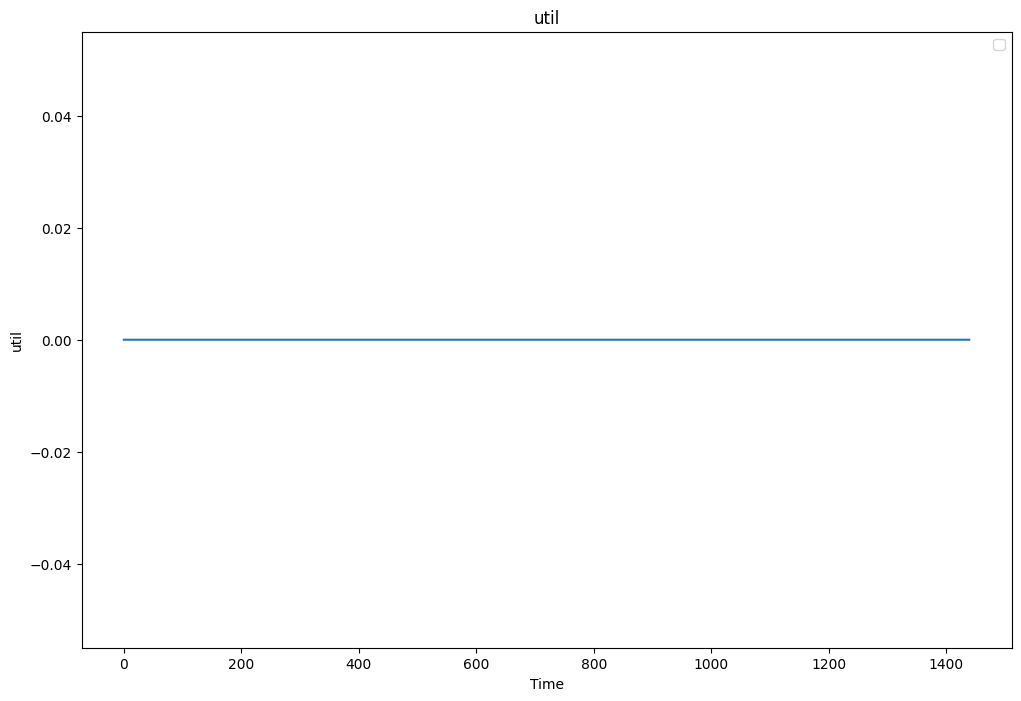

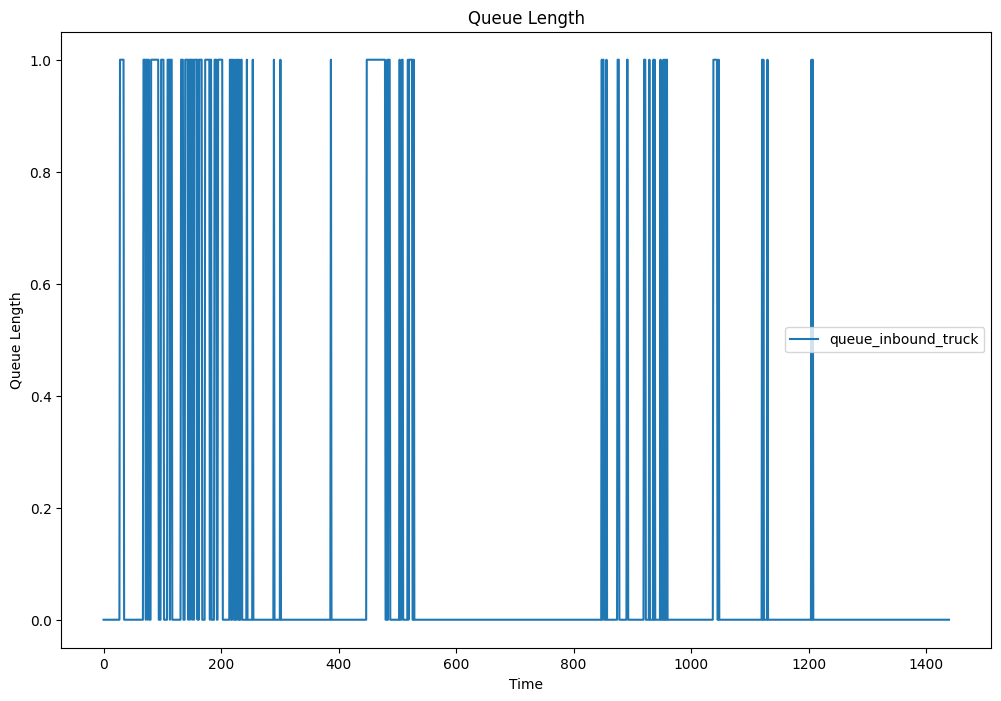

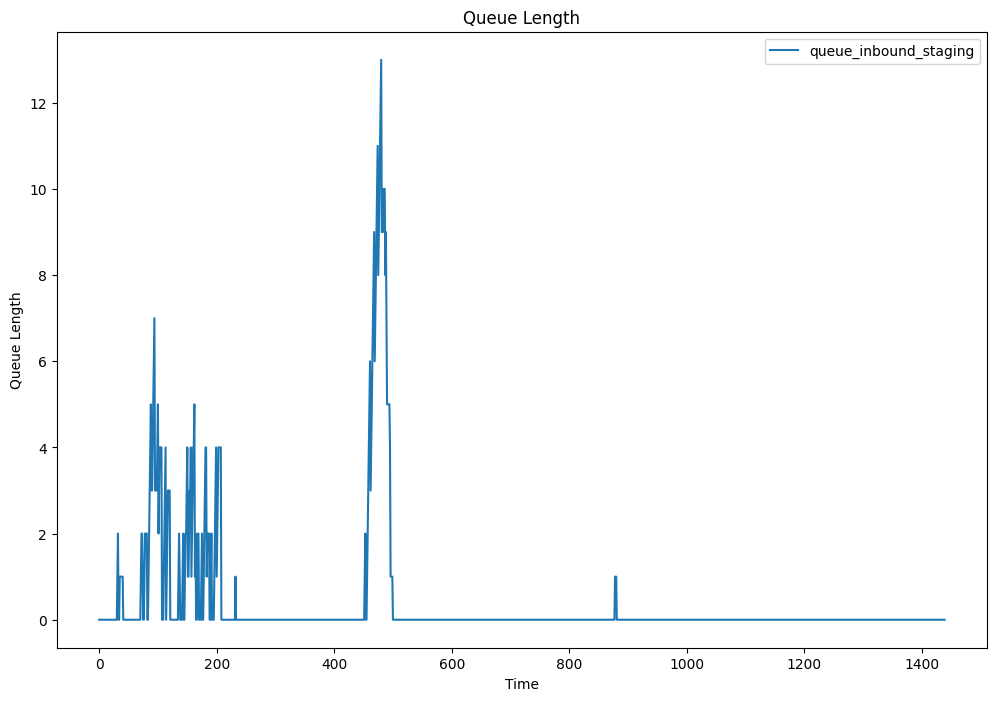

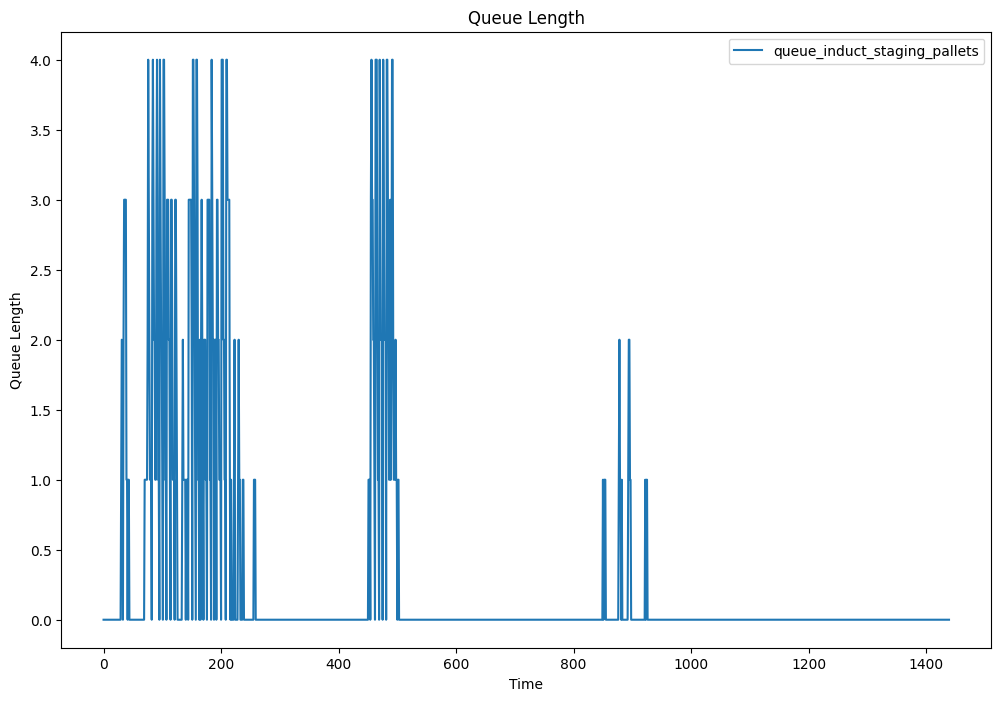

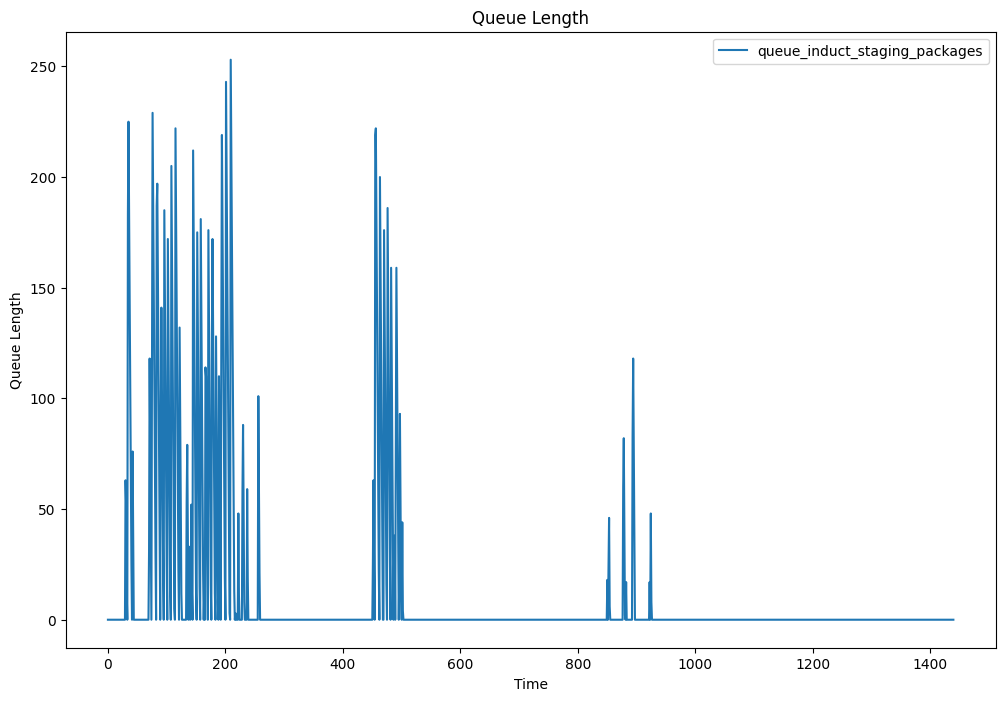

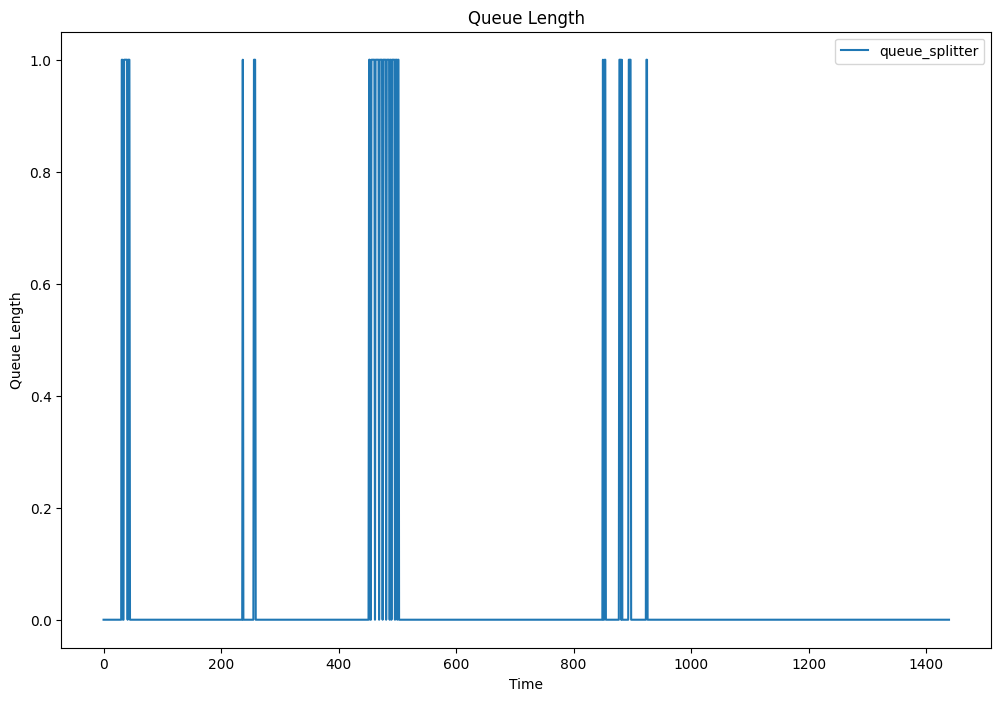

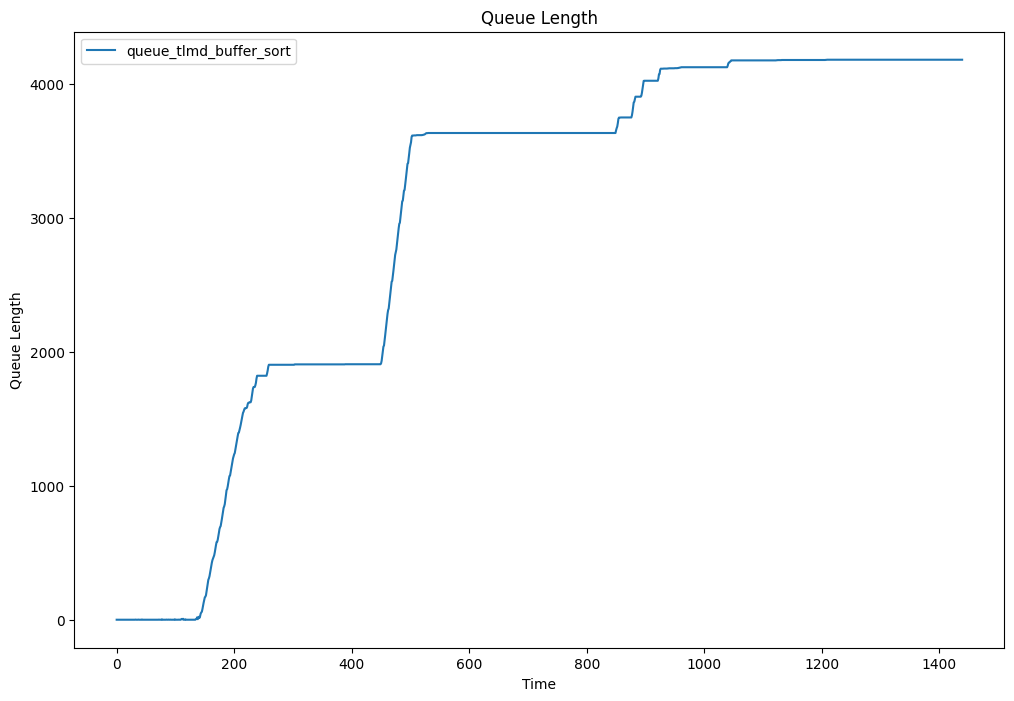

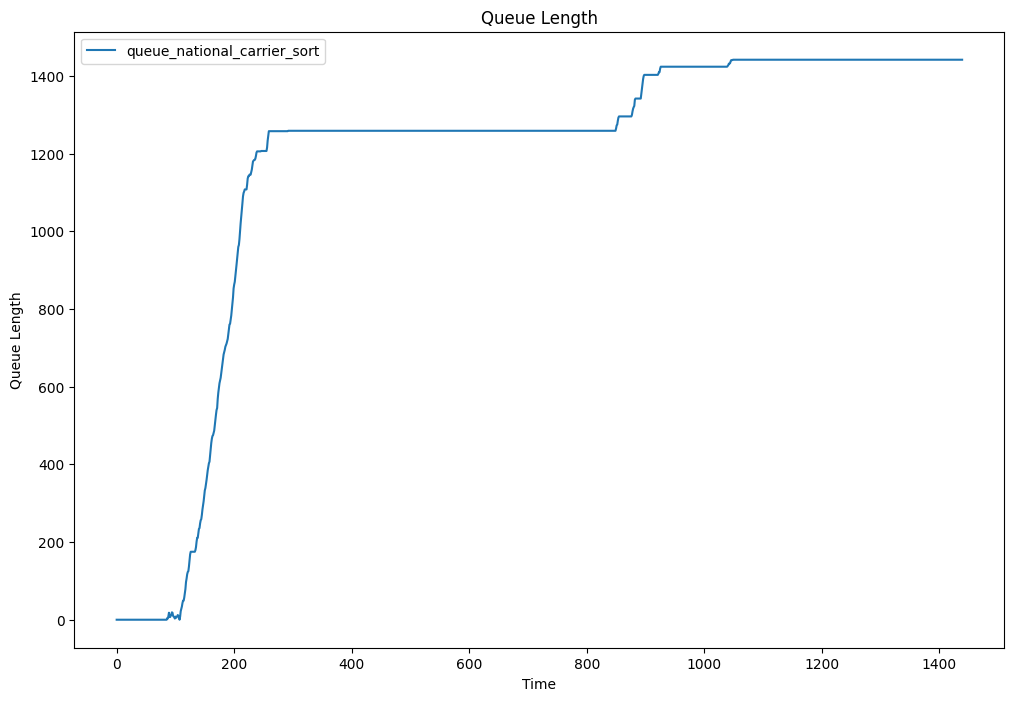

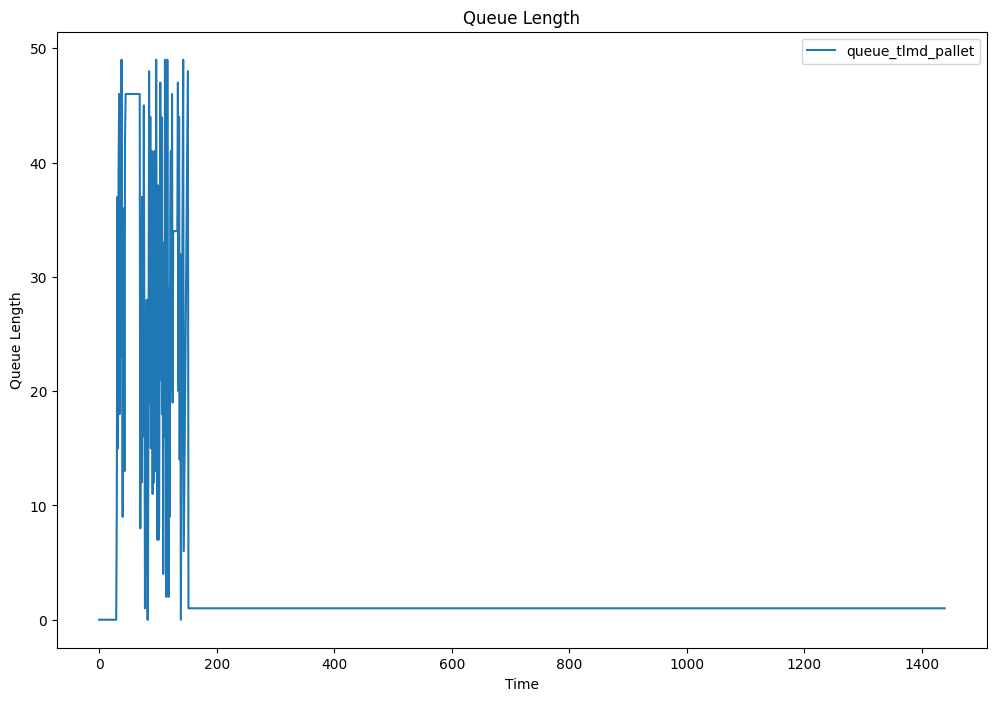

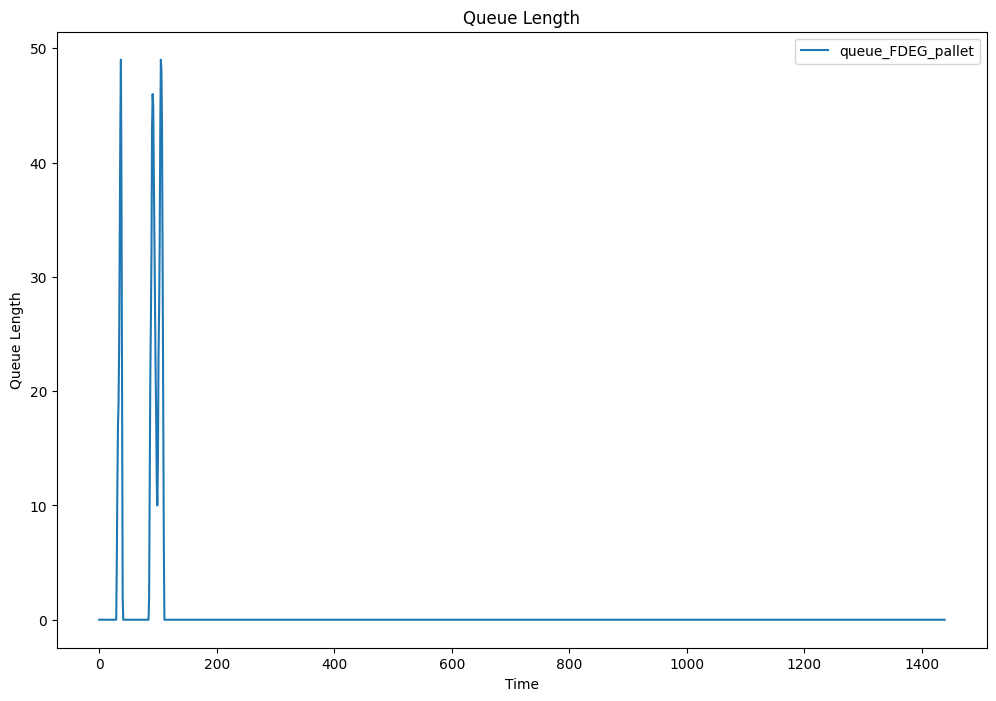

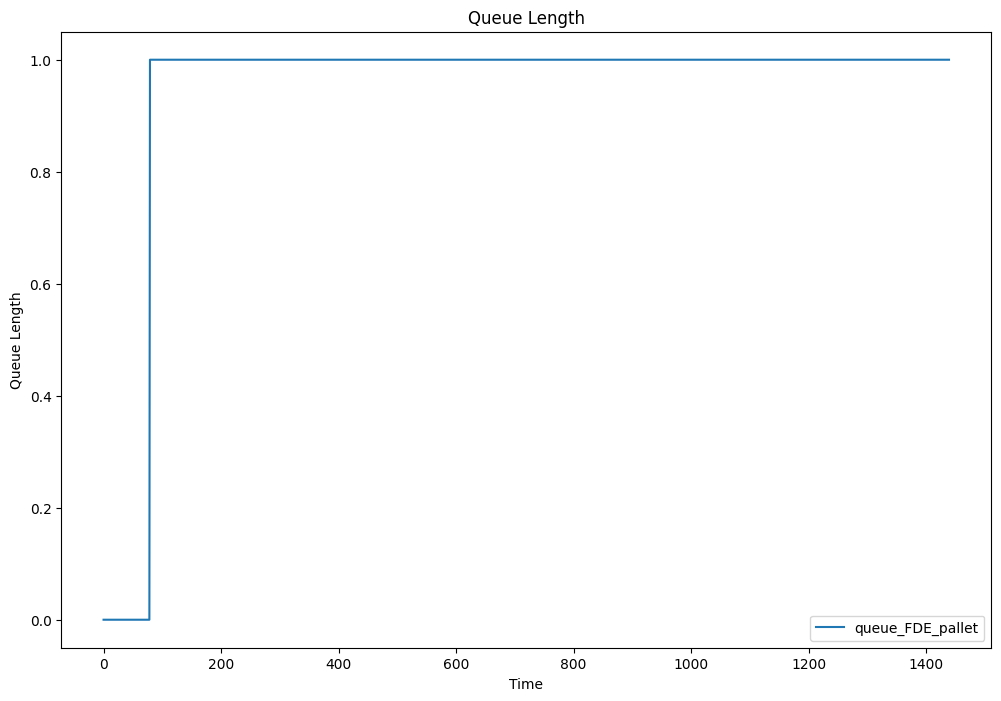

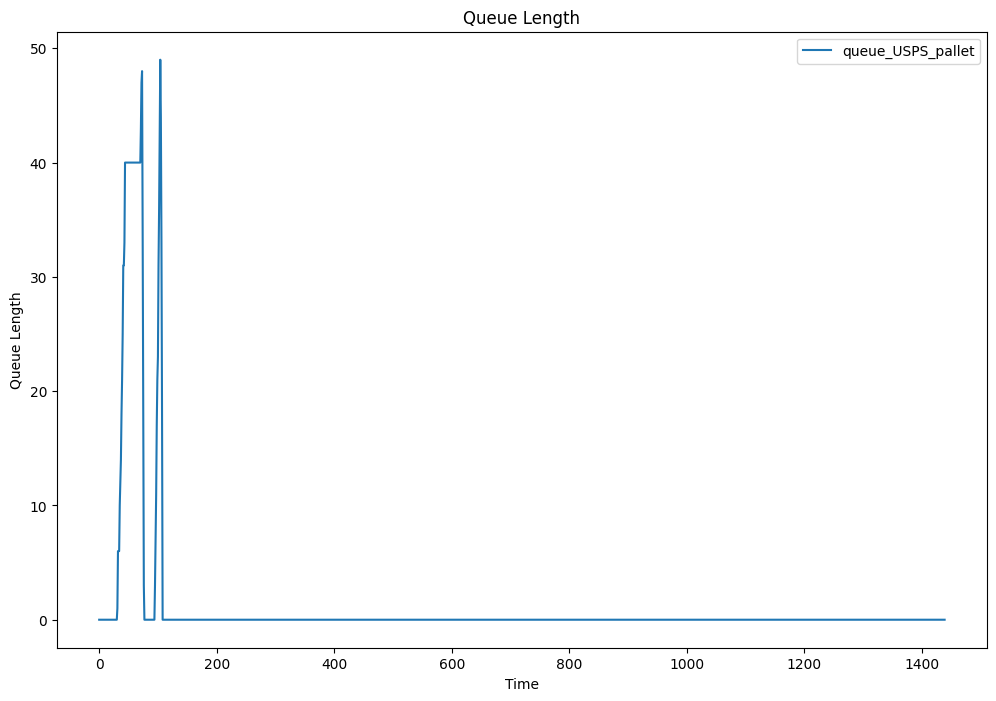

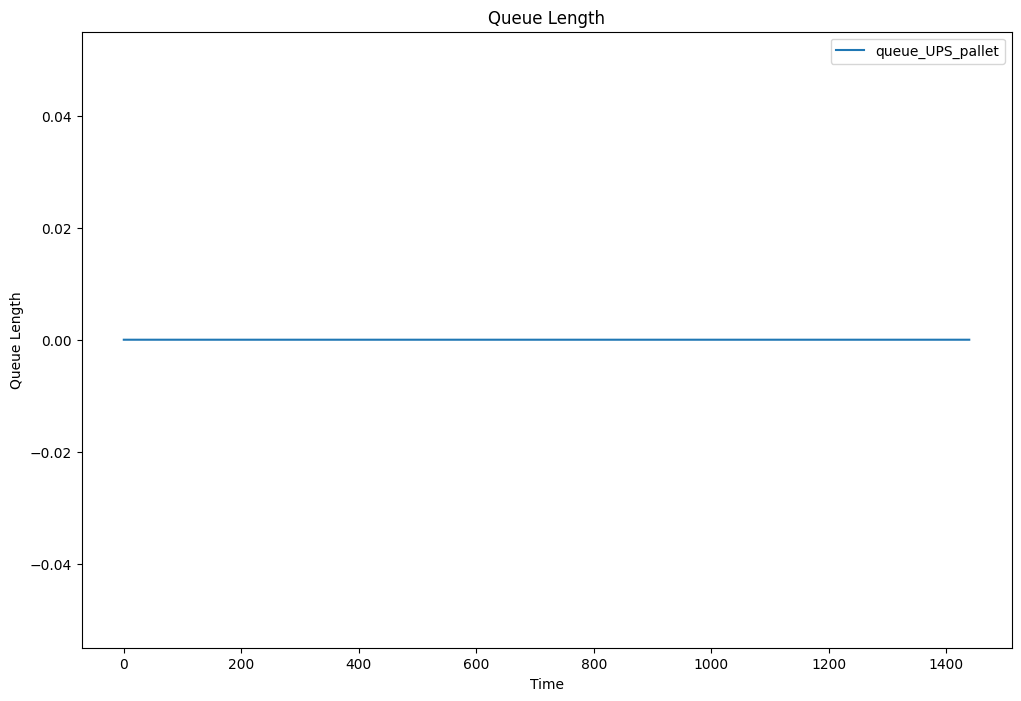

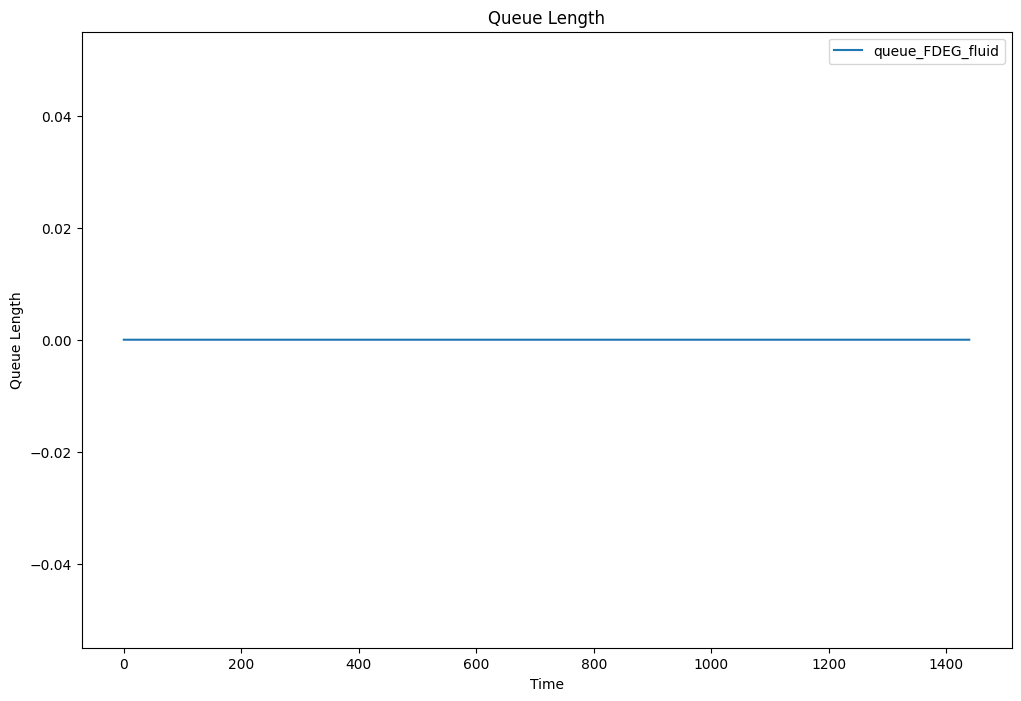

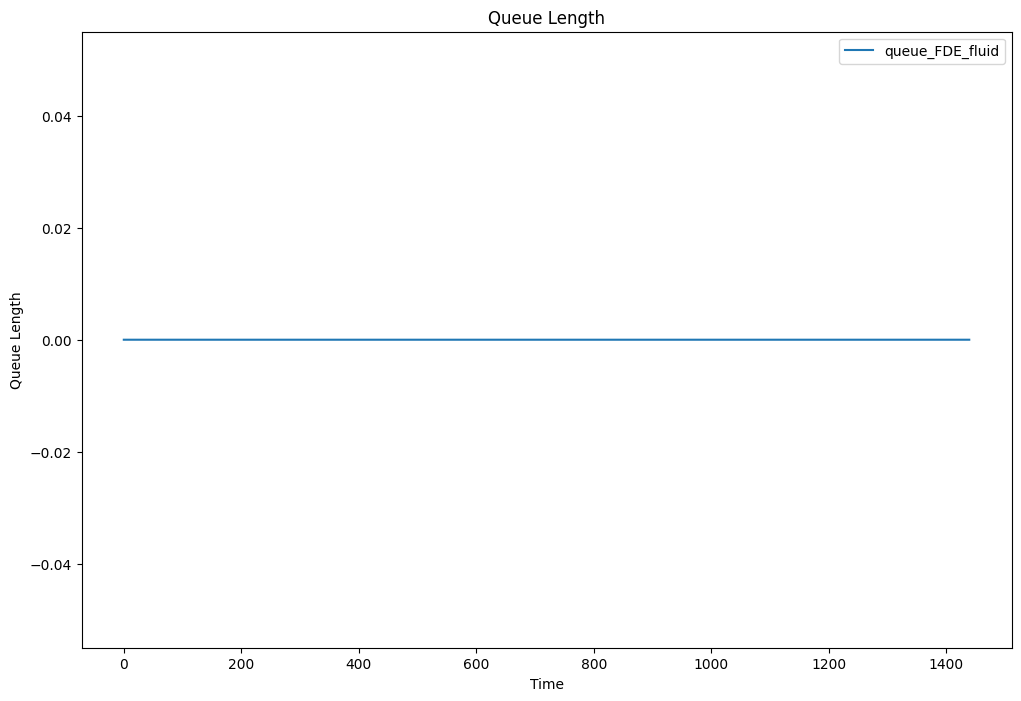

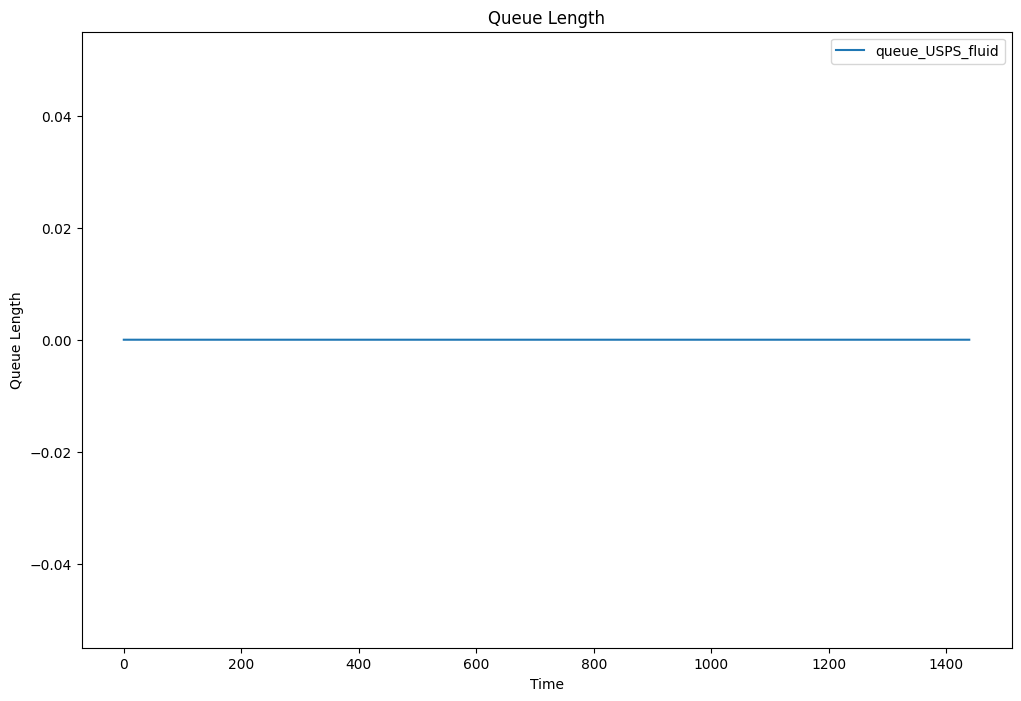

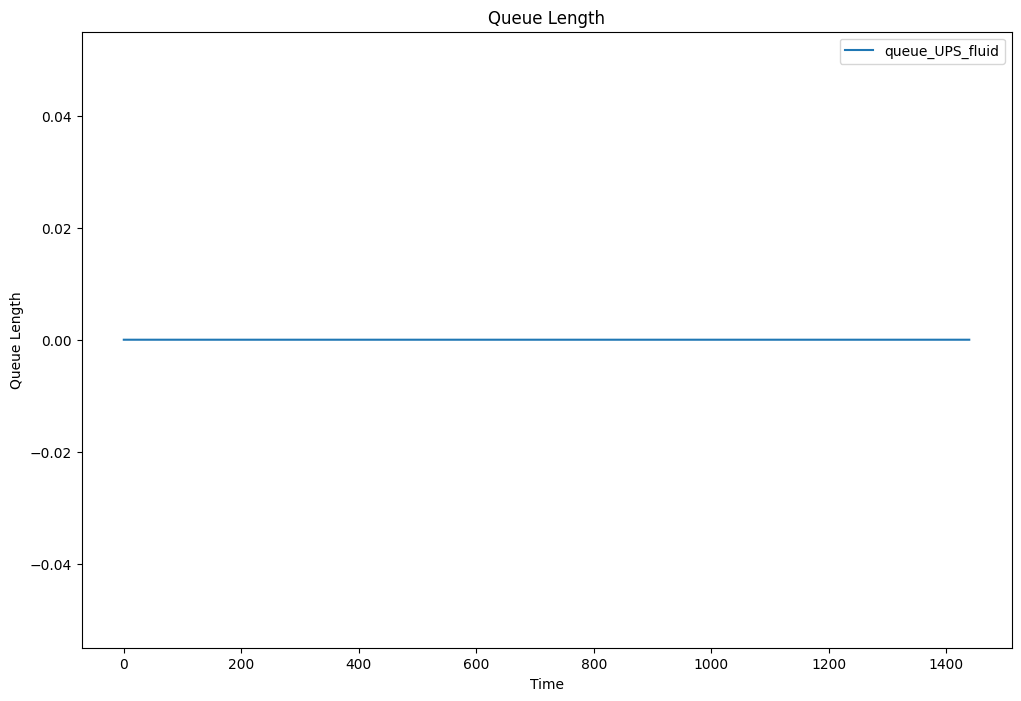

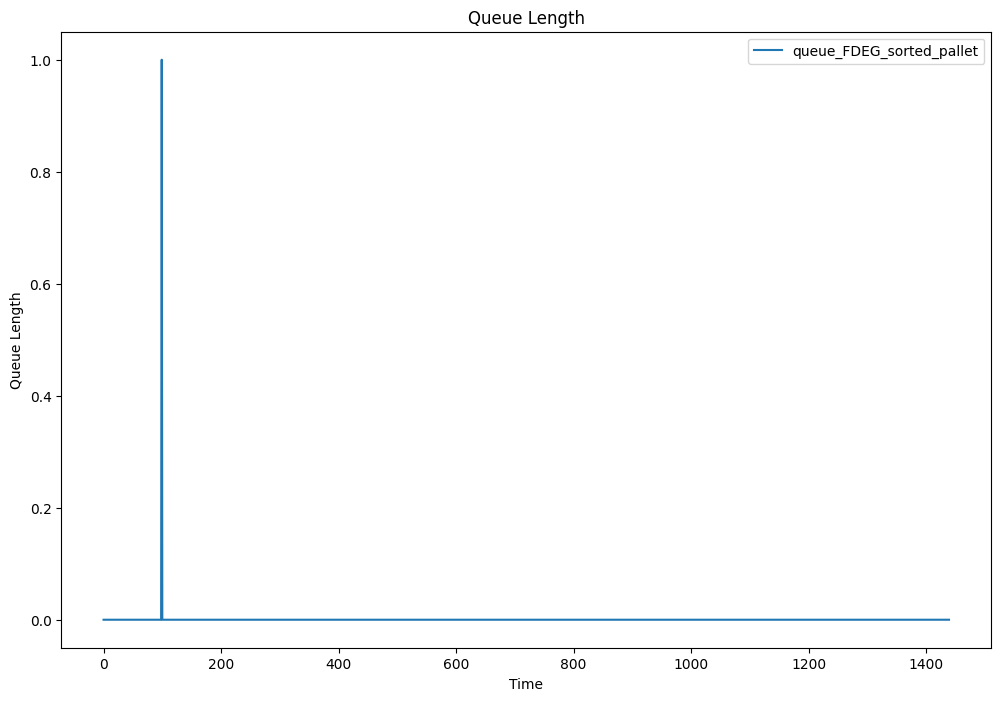

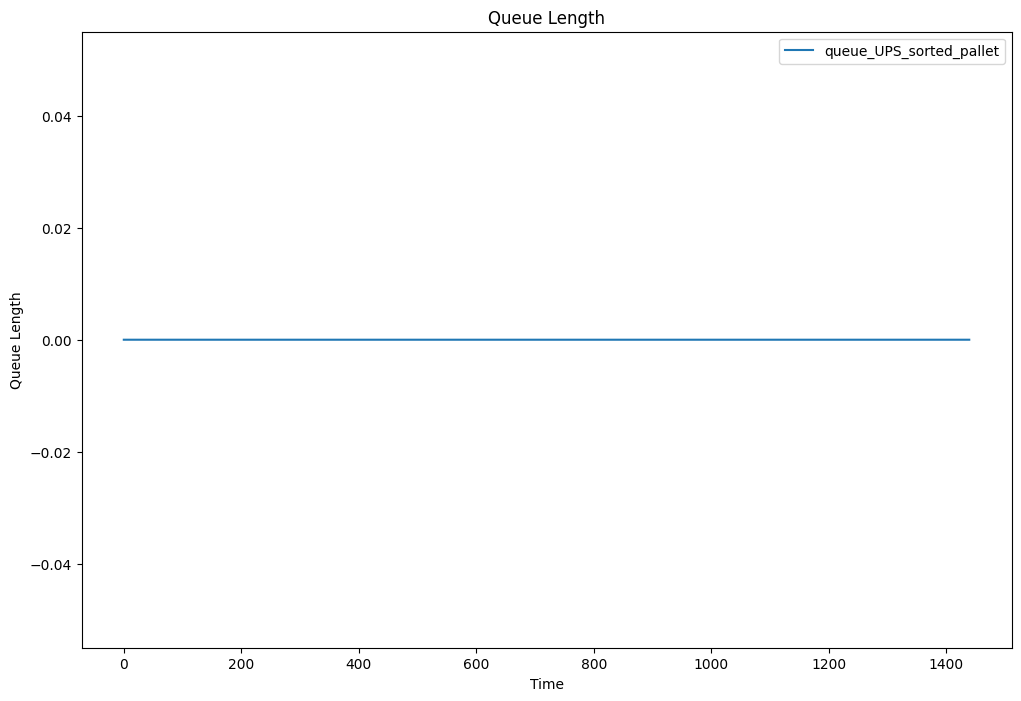

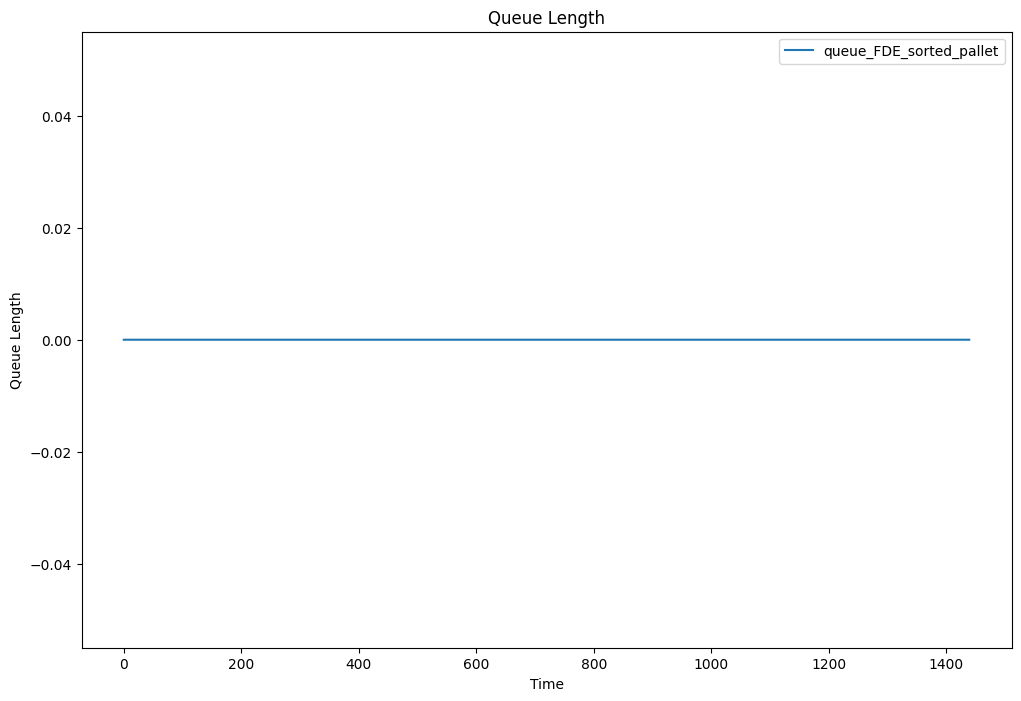

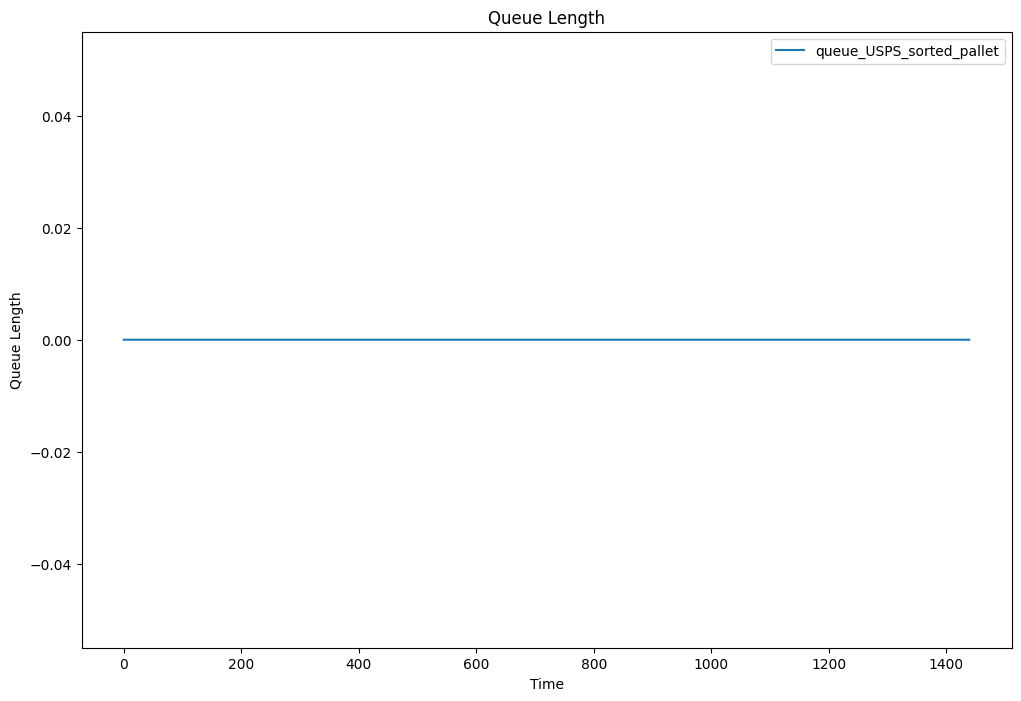

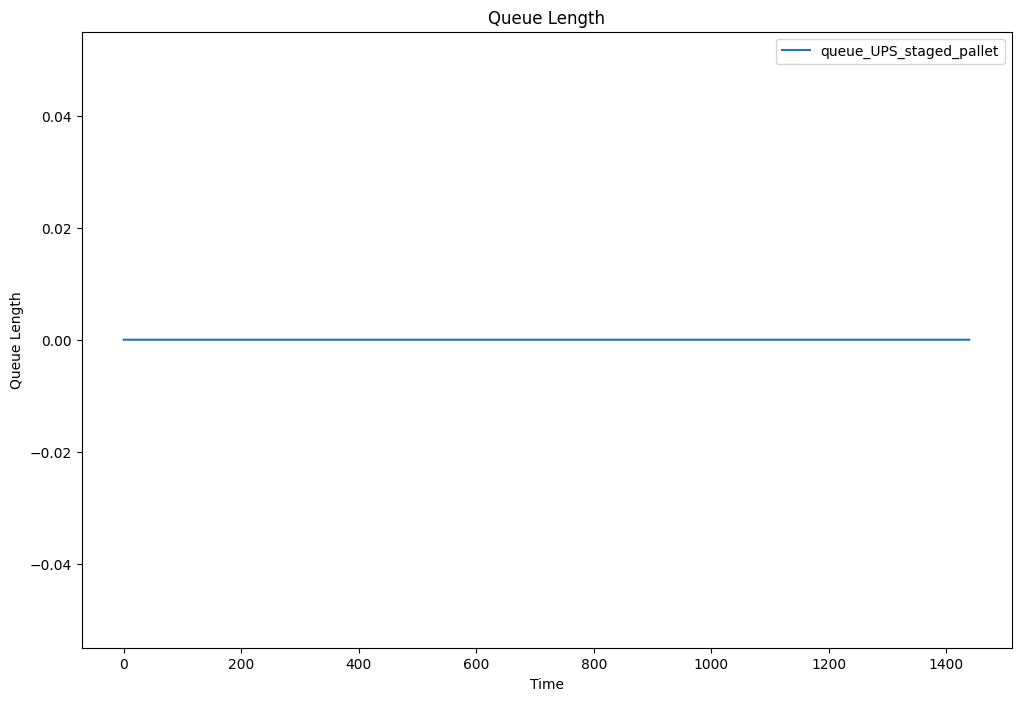

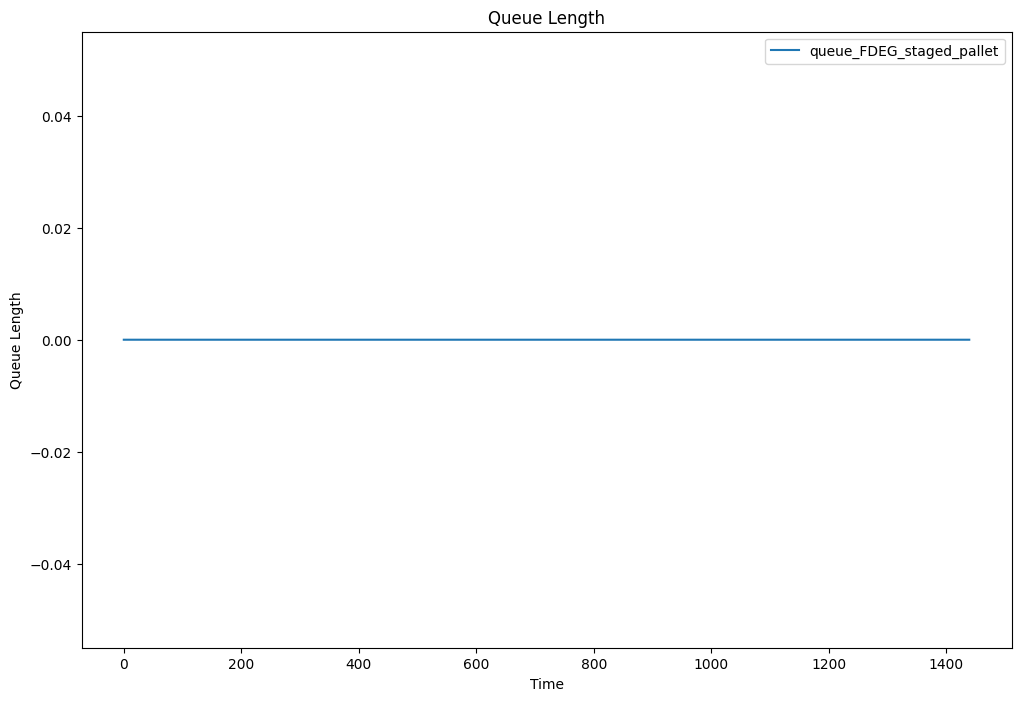

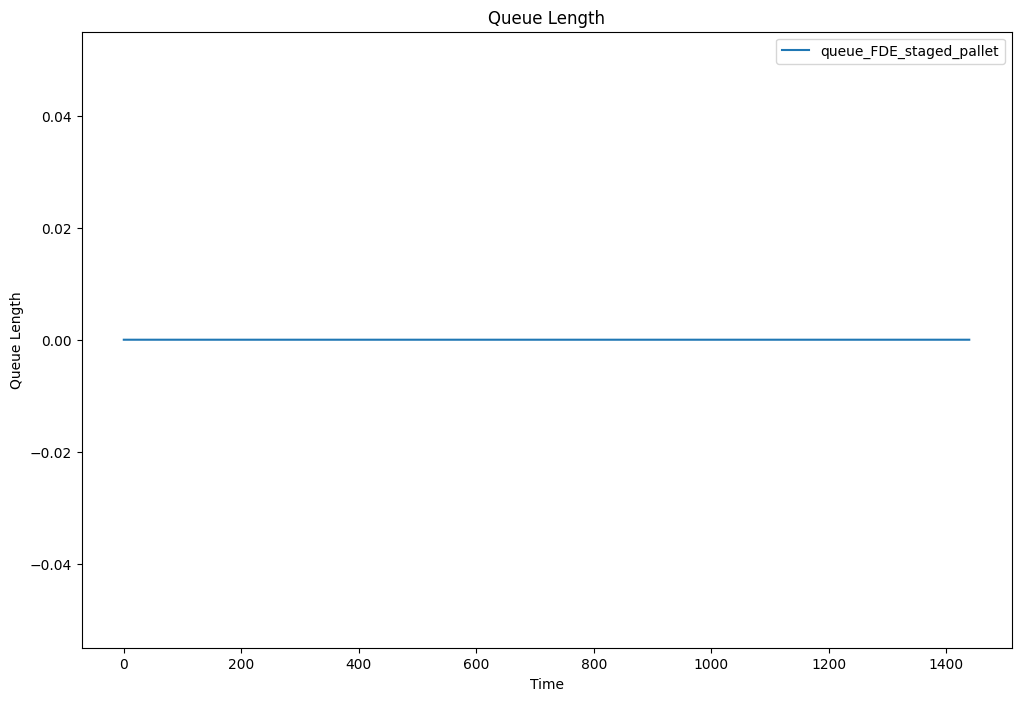

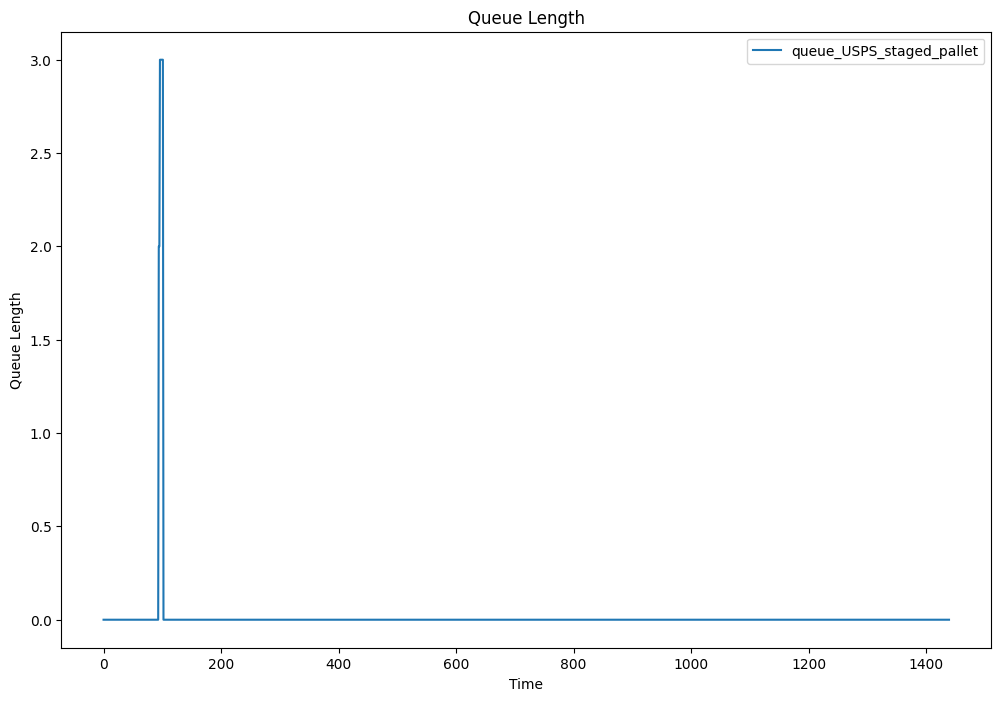

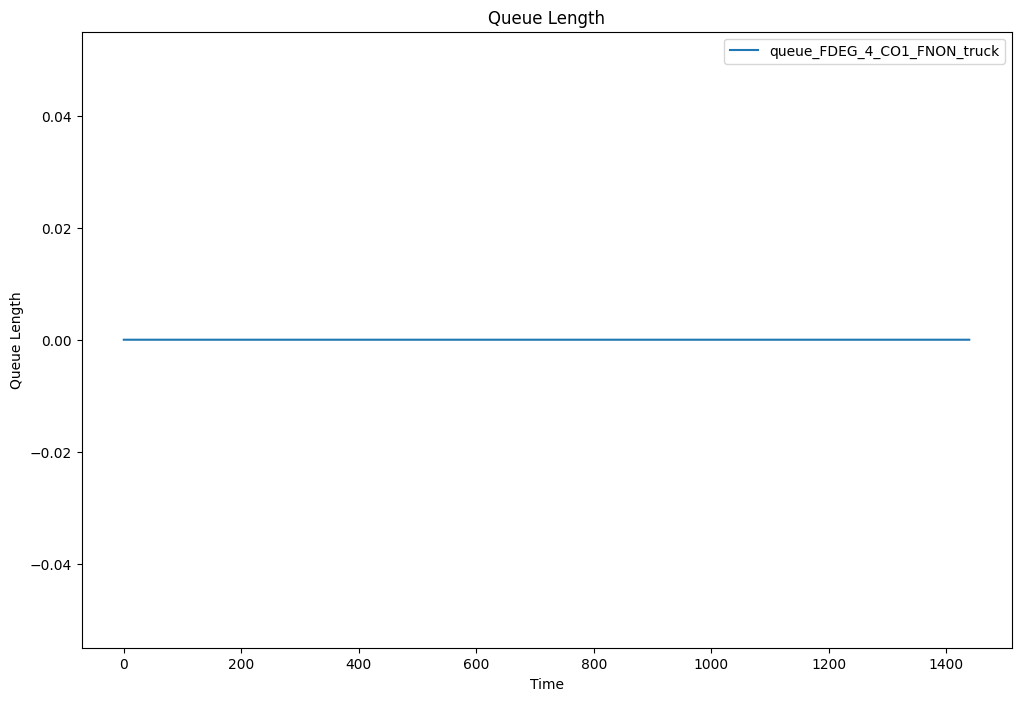

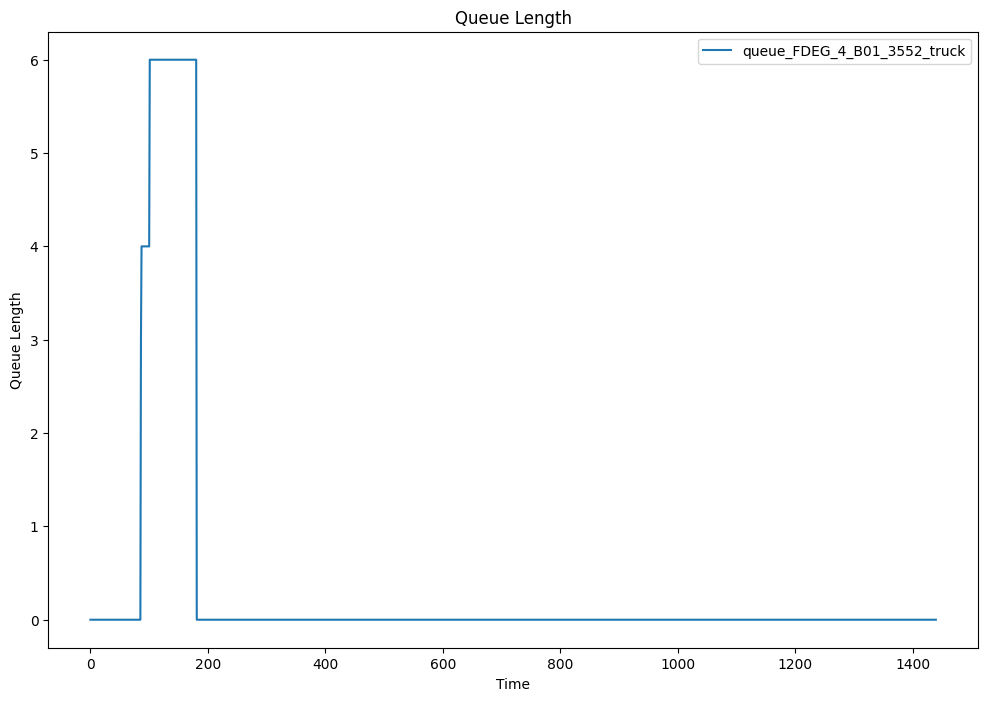

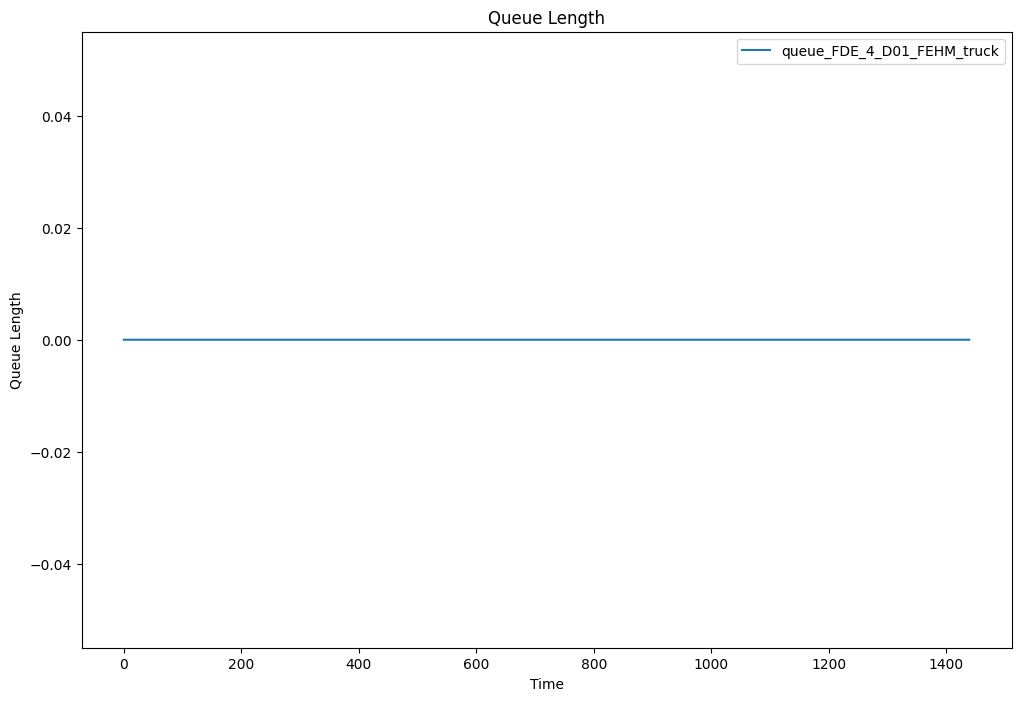

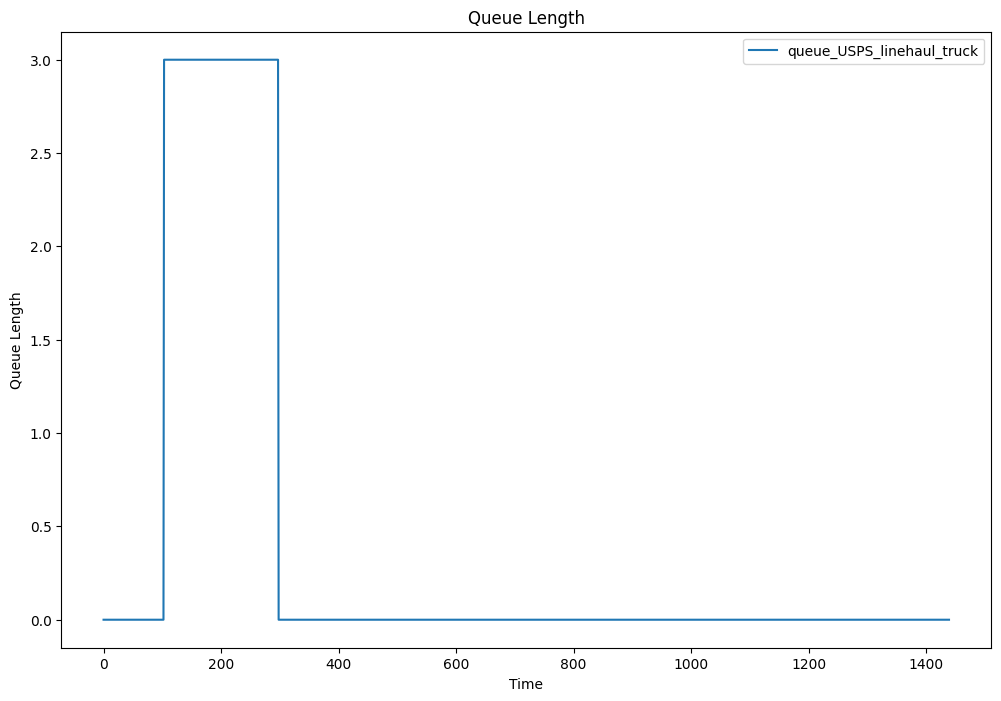

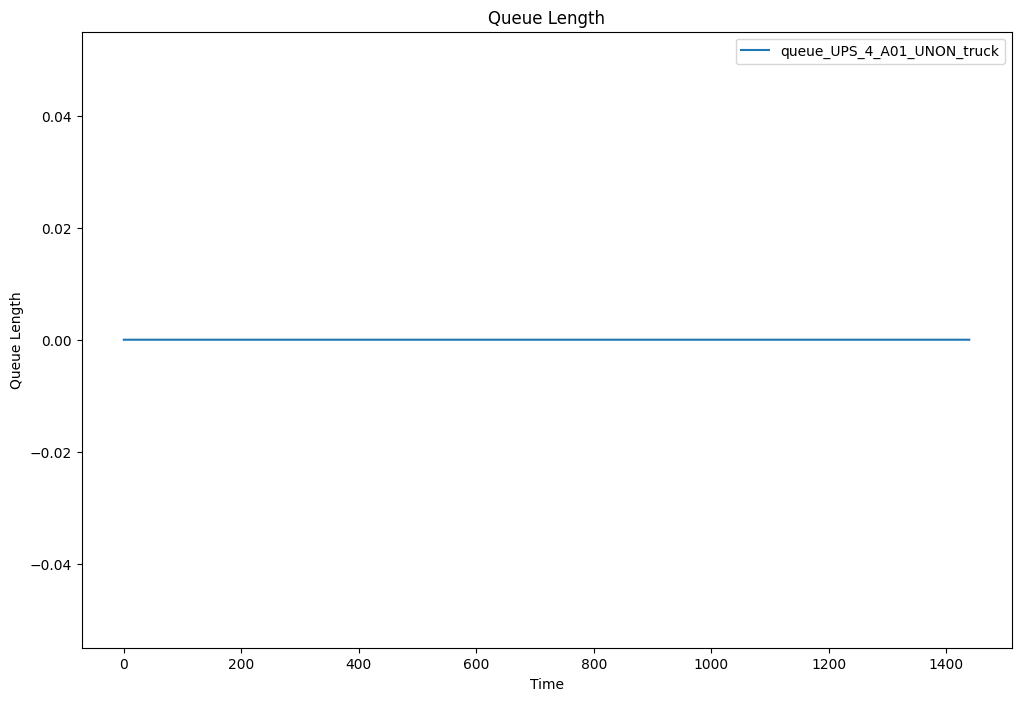

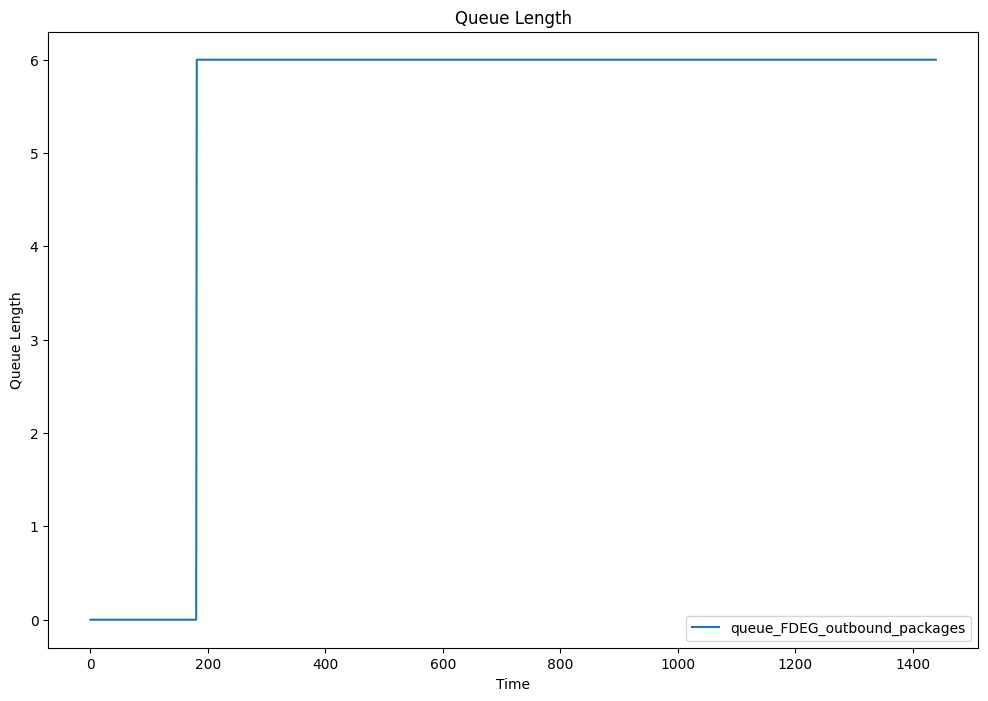

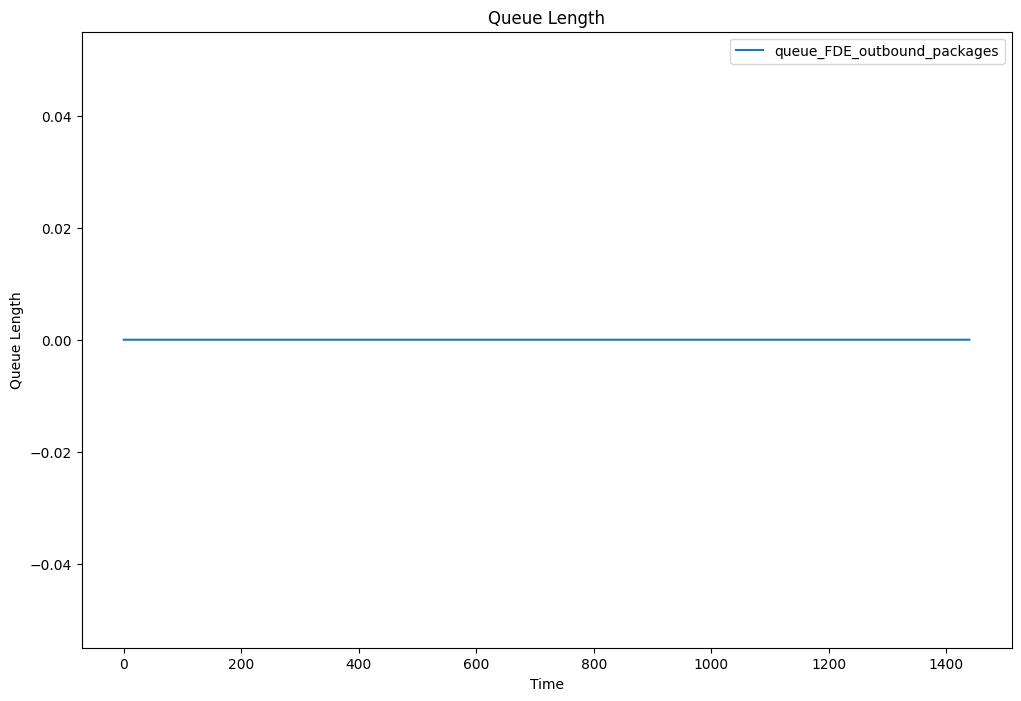

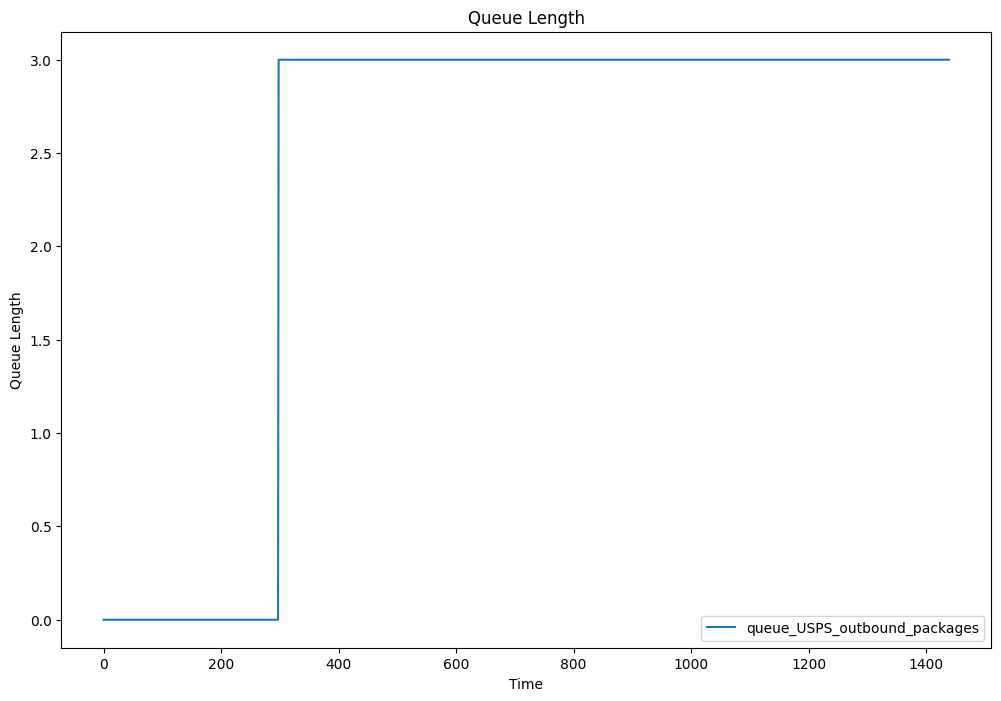

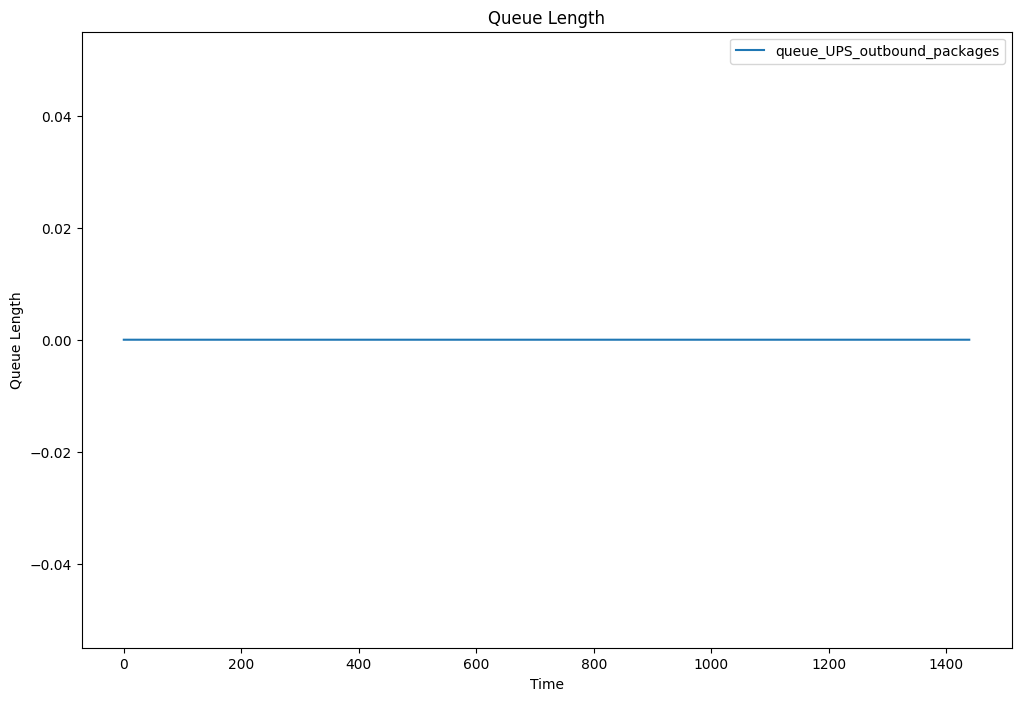

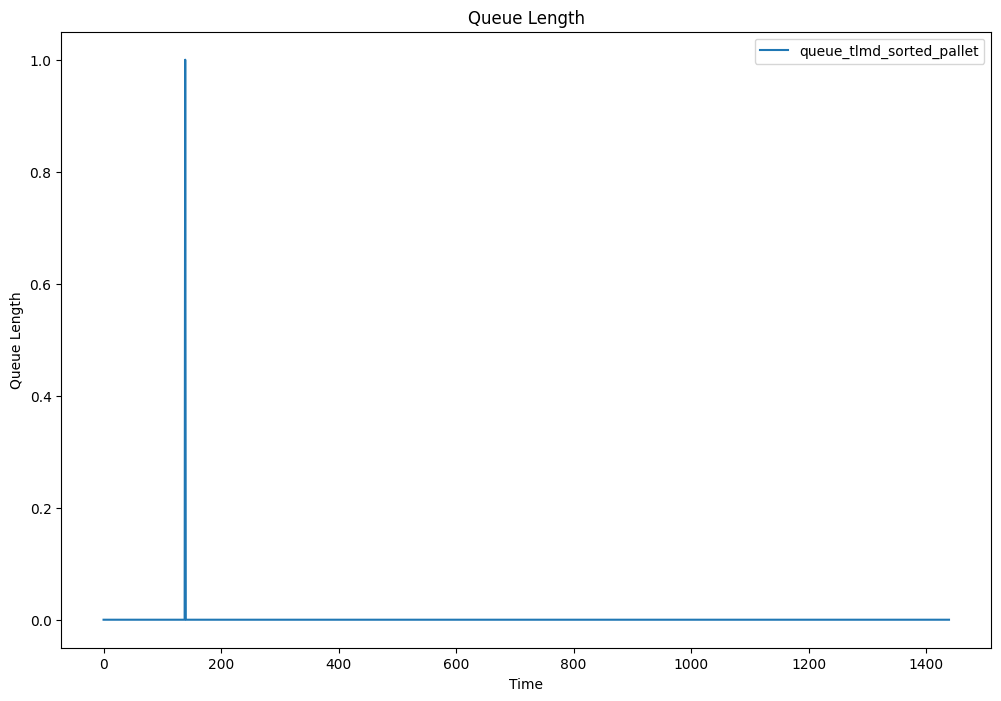

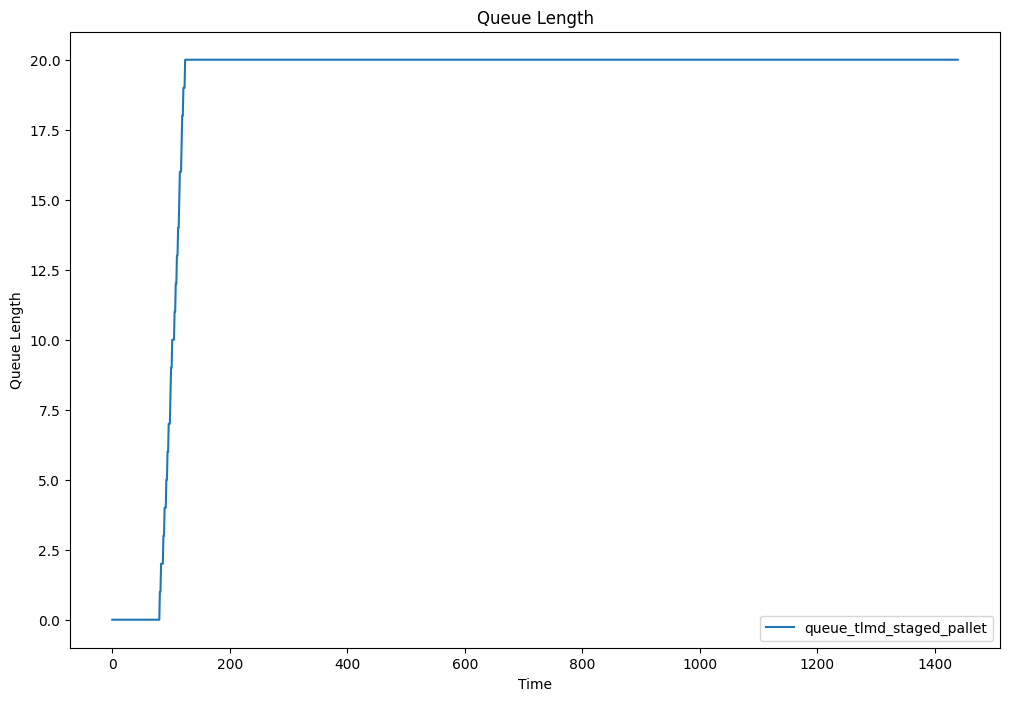

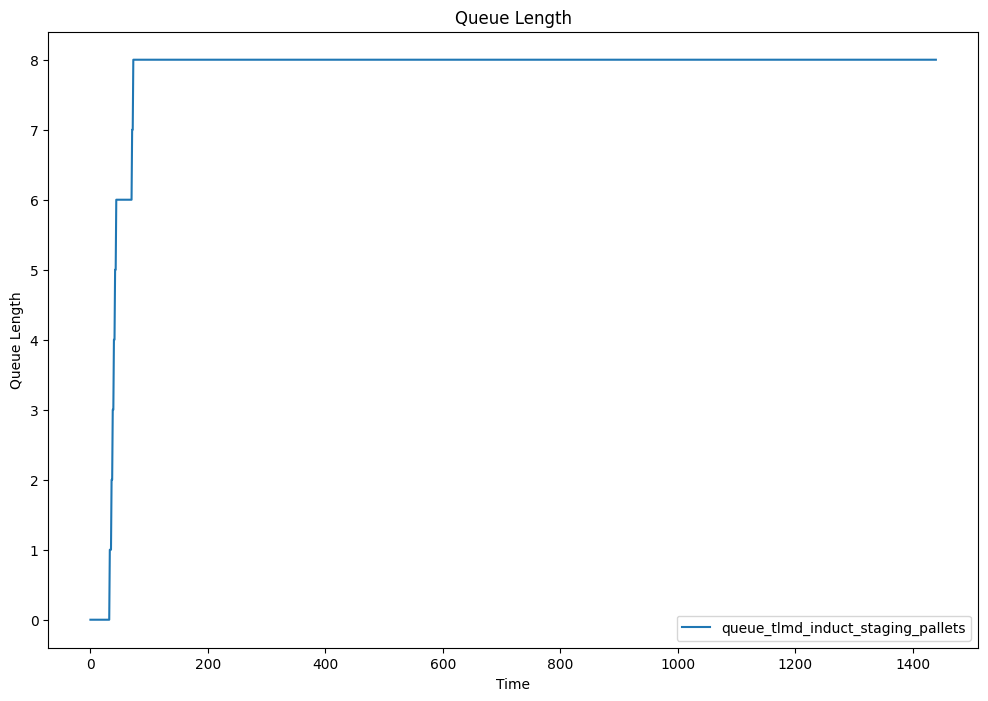

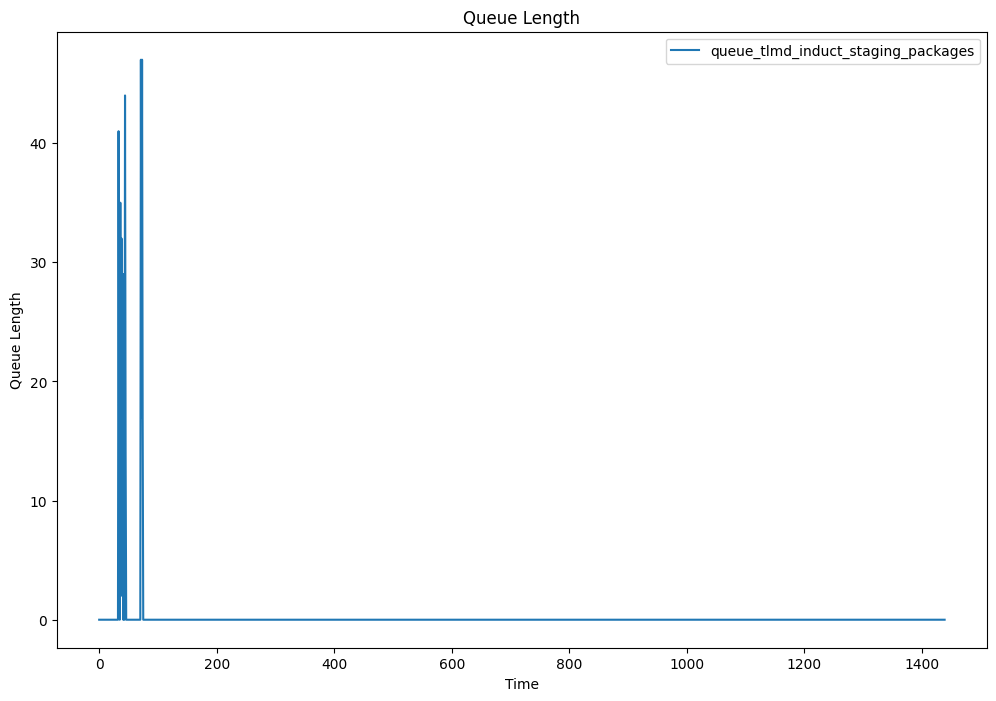

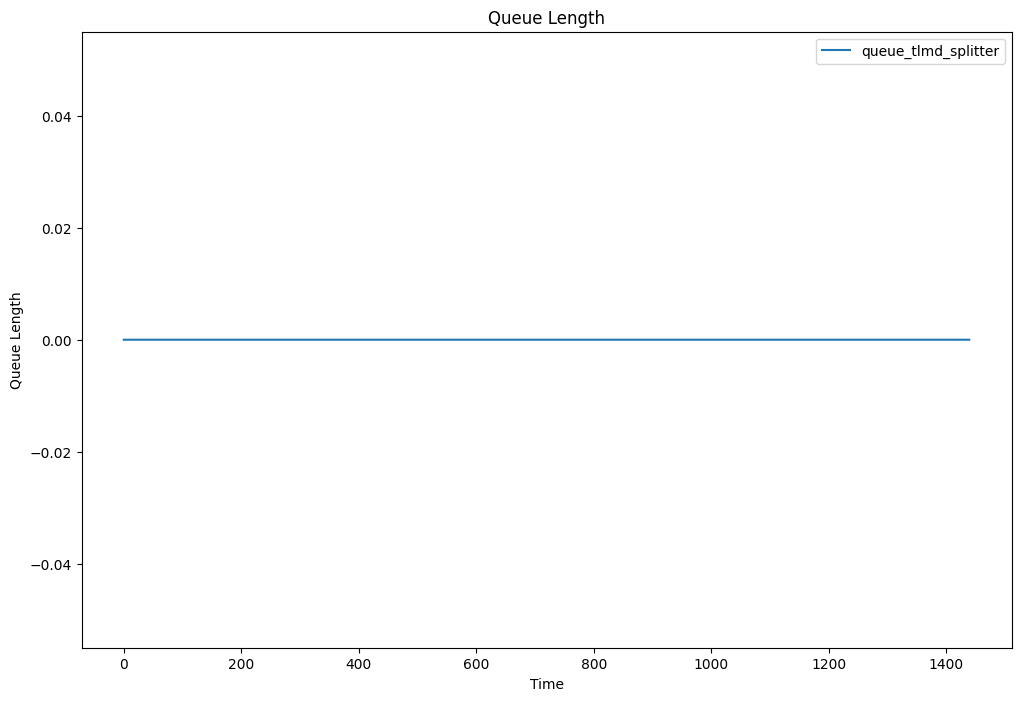

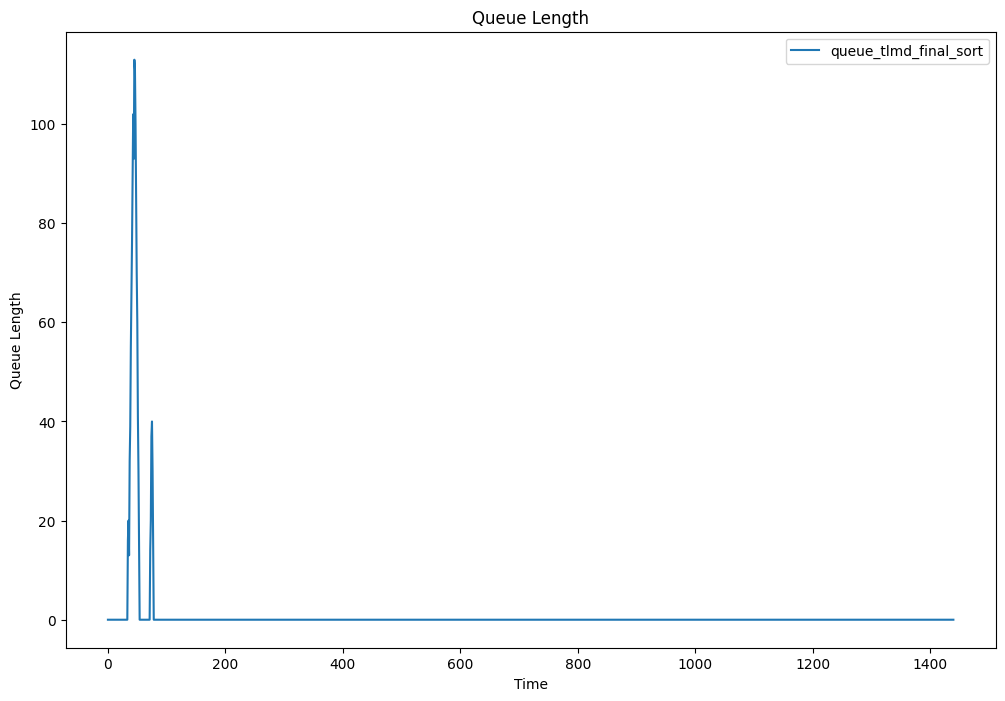

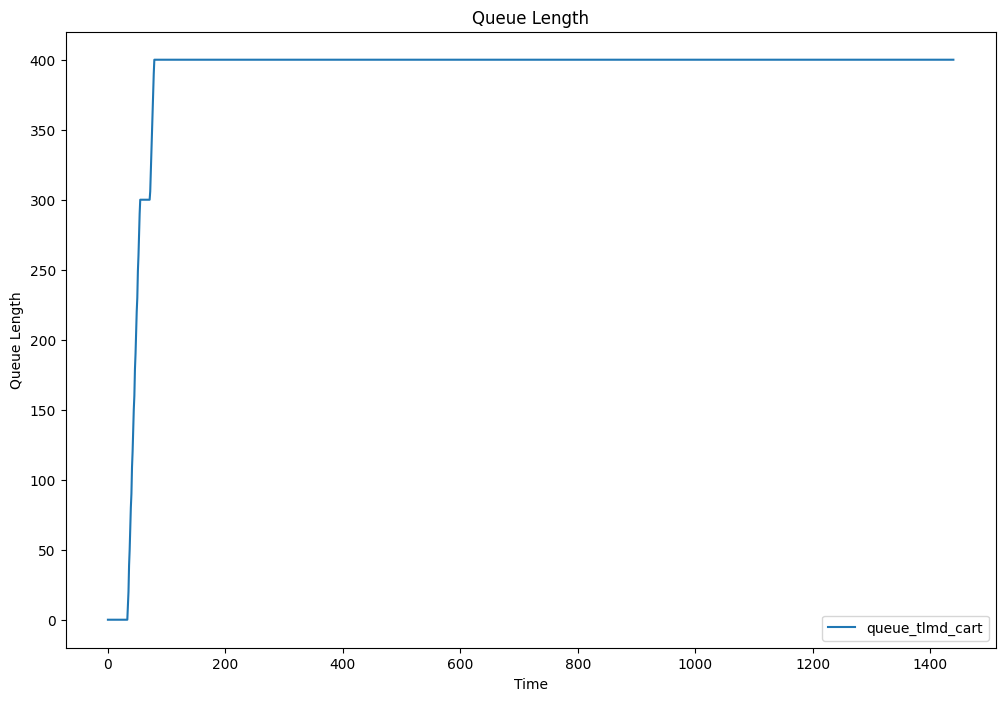

In [50]:
### REV 2.1 ###

import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import simpy

class G:
    # Constants (adjust as needed)
    
    UNLOADING_RATE = 1/4  # minutes per pallet
    INDUCT_STAGE_RATE = 1  # minutes per pallet
    INDUCTION_RATE = 1/10  # minutes per package
    SPLITTER_RATE = 1/60  # minutes per package
    TLMD_BUFFER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_FLUID_PICK_RATE = 1/60  # minutes per package
    NATIONAL_CARRIER_FLUID_LOAD_RATE = 1/12  # minutes per package
    PALLET_BUILD_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_HANDOFF_RATE = 1  # minutes per pallet
    NATIONAL_CARRIER_STAGE_RATE = 1/2  # minutes per pallet
    TLMD_PARTITION_STAGE_RATE = 1  # minutes per pallet
    TLMD_INDUCT_STAGE_RATE = 1/3  # minutes per pallet
    TLMD_INDUCTION_RATE = 1/10  # minutes per package
    TLMD_FINAL_SORT_RATE = 60/84  # minutes per package



    OUTBOUND_NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    

    USPS_DEPARTURE_TIME = [780]  # minutes
    UPS_DEPARTURE_TIME = [1440]  # minutes
    FDEG_DEPARTURE_TIME = [180,390] # minutes
    FDE_DEPARTURE_TIME = [330]  # minutes




class Package:
    def __init__(self, tracking_number, pallet_id, scac):
        self.tracking_number = tracking_number
        self.pallet_id = pallet_id
        self.scac = scac
        self.current_queue = None

class Pallet:
    def __init__(self, env, pallet_id, packages, pkg_received_utc_ts):
        self.env = env
        self.pkg_received_utc_ts = pkg_received_utc_ts
        self.pallet_id = pallet_id
        self.packages = [Package(pkg[0], pallet_id, pkg[1]) for pkg in packages]
        self.current_queue = None
        self.remaining_packages = len(packages)  # Track remaining packages

class TLMD_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages
        
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')

class National_Carrier_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')


def setup_simulation(
                    day_pallets, 
                    tm_pit_unload, 
                    tm_pit_induct, 
                    tm_nonpit_split, 
                    tm_nonpit_NC, 
                    tm_nonpit_buffer,
                    tm_TLMD_induct,
                    tm_TLMD_picker,
                    tm_TLMD_sort):
    
    total_TMs_night = tm_pit_unload + tm_pit_induct + tm_nonpit_split + tm_nonpit_NC + tm_nonpit_buffer
    total_TMs_day = tm_TLMD_induct + tm_TLMD_picker + tm_TLMD_sort
    total_packages = sum([len(row['packages']) for i, row in day_pallets.iterrows()])

    Fluid_status = True
    if total_TMs_night <20:
        Fluid_status = False
    if total_packages < 10000:
        Fluid_status = False

    env = simpy.Environment()

    sortation_center = Sortation_Center(
                                        env, day_pallets, 
                                        tm_pit_unload, 
                                        tm_pit_induct, 
                                        tm_nonpit_split, 
                                        tm_nonpit_NC, 
                                        tm_nonpit_buffer,
                                        tm_TLMD_induct,
                                        tm_TLMD_picker, 
                                        tm_TLMD_sort,
                                        Fluid_status)
    
    env.process(sortation_center.track_metrics())
    sortation_center.schedule_arrivals()
    return env, sortation_center

class Sortation_Center:
    def __init__(self, 
                 env, 
                 pallets_df, 
                 tm_pit_unload, 
                 tm_pit_induct, 
                 tm_nonpit_split, 
                 tm_nonpit_NC, 
                 tm_nonpit_buffer,
                 tm_TLMD_induct, 
                 tm_TLMD_picker,
                 tm_TLMD_sort,
                 Fluid_status):
        self.env = env
        self.pallets_df = pallets_df
        self.tm_pit_unload = simpy.Resource(env, capacity=tm_pit_unload)
        self.tm_pit_induct = simpy.PriorityResource(env, capacity=tm_pit_induct)
        self.tm_nonpit_split = simpy.Resource(env, capacity=tm_nonpit_split)
        self.tm_nonpit_NC = simpy.PriorityResource(env, capacity=tm_nonpit_NC)
        self.tm_nonpit_buffer = simpy.PriorityResource(env, capacity=tm_nonpit_buffer)
        self.tm_TLMD_induct = simpy.PriorityResource(env, capacity=tm_TLMD_induct)
        self.tm_TLMD_picker = simpy.Resource(env, capacity=tm_TLMD_picker)
        self.tm_TLMD_sort = simpy.Resource(env, capacity=tm_TLMD_sort)
        self.Fluid_status = Fluid_status

        self.queues = {
            "queue_inbound_truck": simpy.Store(self.env, capacity=6),
            "queue_inbound_staging": simpy.Store(self.env, capacity=200),
            "queue_induct_staging_pallets": simpy.Store(self.env, capacity=10),
            "queue_induct_staging_packages": simpy.Store(self.env),
            "queue_splitter": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_buffer_sort": simpy.Store(self.env, capacity=100000),
            "queue_national_carrier_sort": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDE_pallet": simpy.Store(self.env, capacity=100000),
            "queue_USPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_UPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_fluid": simpy.Store(self.env, capacity=10),
            "queue_FDE_fluid": simpy.Store(self.env, capacity=10),
            "queue_USPS_fluid": simpy.Store(self.env, capacity=10),
            "queue_UPS_fluid": simpy.Store(self.env, capacity=10),
            'queue_FDEG_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_FDE_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_USPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDE_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_USPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_4_CO1_FNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_4_B01_3552_truck': simpy.Store(self.env, capacity=26),
            'queue_FDE_4_D01_FEHM_truck': simpy.Store(self.env, capacity=26),
            'queue_USPS_linehaul_truck': simpy.Store(self.env, capacity=26),
            'queue_UPS_4_A01_UNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_outbound_packages': simpy.Store(self.env),
            'queue_FDE_outbound_packages': simpy.Store(self.env),
            'queue_USPS_outbound_packages': simpy.Store(self.env),
            'queue_UPS_outbound_packages': simpy.Store(self.env),
            'queue_tlmd_sorted_pallet': simpy.Store(self.env),
            'queue_tlmd_staged_pallet': simpy.Store(self.env, capacity=20),
            'queue_tlmd_induct_staging_pallets': simpy.Store(self.env, capacity=8),
            'queue_tlmd_induct_staging_packages': simpy.Store(self.env),
            'queue_tlmd_splitter': simpy.Store(self.env),
            'queue_tlmd_final_sort': simpy.Store(self.env),
            'queue_tlmd_cart': simpy.Store(self.env)
            
            
        }
        self.metrics = {
            "processing_times": [],
            "queue_lengths": {key: [] for key in self.queues.keys()},
            "resource_utilization": [],
        }

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics["queue_lengths"][key].append(len(queue.items))
            self.metrics["resource_utilization"].append(
                len(self.tm_pit_unload.queue)
            )
            yield self.env.timeout(1)


###################################################
##### Begin Inbound Truck Arrival Input ###########
###################################################

    def schedule_arrivals(self):
        for i, row in self.pallets_df.iterrows():
            pallet = Pallet(
                self.env,
                row['Pallet'],
                row['packages'],
                row['earliest_arrival']
            )
            self.env.process(self.truck_arrival(pallet))

    def truck_arrival(self, pallet):
        yield self.env.timeout(pallet.pkg_received_utc_ts)  # Arrival time
        pallet.current_queue = "queue_inbound_truck"
        print(f"Pallet {pallet.pallet_id} arrived at {self.env.now}")
        yield self.queues["queue_inbound_truck"].put(pallet)
        self.env.process(self.unload_truck(pallet))

###################################################
##### Begin Pit Unload and Induction Process ######
###################################################

    def unload_truck(self, pallet):
        with self.tm_pit_unload.request() as req:
            yield req
            yield self.queues["queue_inbound_truck"].get()
            yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
            pallet.current_queue = "queue_inbound_staging"
            print(f"Pallet {pallet.pallet_id} unloaded at {self.env.now}")
            yield self.queues["queue_inbound_staging"].put(pallet)
            self.env.process(self.move_to_induct_staging(pallet))
    
    def move_to_induct_staging(self, pallet):
        with self.tm_pit_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues["queue_inbound_staging"].get()
            yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = "queue_induct_staging_pallets"
            yield self.queues["queue_induct_staging_pallets"].put(pallet)
            print(f"Pallet {pallet.pallet_id} staged for induction at {self.env.now}")
            for package in pallet.packages:
                package.current_queue = "queue_induct_staging_packages"
                yield self.queues["queue_induct_staging_packages"].put(package)
                self.env.process(self.induct_package(package, pallet))

    def induct_package(self, package, pallet):
        with self.tm_pit_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues["queue_induct_staging_packages"].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = "queue_splitter"
            print(f"Package {package.tracking_number}, {package.scac} inducted at {self.env.now}")
            yield self.queues["queue_splitter"].put(package)
            pallet.remaining_packages -= 1  # Decrement the counter
            if pallet.remaining_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.split_package(package))

    def remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues["queue_induct_staging_pallets"].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues["queue_induct_staging_pallets"].items[i]
                print(f"Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}")
                break

    def split_package(self, package):
        with self.tm_nonpit_split.request() as req:
            yield req
            yield self.queues["queue_splitter"].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            if package.scac in ['UPS', 'USPS', 'FDEG', 'FDE']:
                package.current_queue = "queue_national_carrier_sort"
                print(f"Package {package.tracking_number} split to National Sort at {self.env.now}")
                yield self.queues["queue_national_carrier_sort"].put(package)
                self.env.process(self.national_carrier_sort(package))
            else:
                package.current_queue = "queue_tlmd_buffer_sort"
                print(f"Package {package.tracking_number} split to TLMD Buffer at {self.env.now}")
                yield self.queues["queue_tlmd_buffer_sort"].put(package)
                self.env.process(self.tlmd_buffer_sort(package))


###################################################
##### Begin National Carrier Sortation Process#####
###################################################

#Split between fluid and pallet sort will occur as a part of the logic established in setup function. 
# Current logic is set to split based on total TM count and total package count. 
# Current logic is a light switch to do national carrier as fluid or a pallet. there is no mix.

##########################################################
##### Begin National Carrier Pallet Sortation Process#####
##########################################################

    def national_carrier_sort(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_national_carrier_sort"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
            if package.scac in ['UPSN']:
                if self.Fluid_status == False:
                    yield self.queues["queue_UPS_pallet"].put(package)
                    self.env.process(self.UPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_UPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_UPS(package))
                else:
                    print("No UPS Pallet or Fluid")
            if package.scac in ['USPS']:
                if self.Fluid_status == False:
                    yield self.queues["queue_USPS_pallet"].put(package)
                    self.env.process(self.USPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_USPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_USPS(package))
                else:
                    print("No USPS Pallet or Fluid")
            elif package.scac in ['FDEG']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDEG_pallet"].put(package)
                    self.env.process(self.FDEG_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDEG_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDEG(package))
                else:
                    print("No FDEG Pallet or Fluid")
            elif package.scac in ['FDE']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDE_pallet"].put(package)
                    self.env.process(self.FDE_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDE_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDE(package))
                else:
                    print("No FDE Pallet or Fluid")


    #UPS
    
    def UPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_UPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_UPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"UPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_UPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.UPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
    
    def UPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_UPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.packages} staged for UPS pickup at {self.env.now}")
            yield self.queues["queue_UPS_staged_pallet"].put(pallet)
            self.env.process(self.UPS_pallet_loaded(pallet))

    def UPS_pallet_loaded(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            yield self.queues["queue_UPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet.packages} loaded to UPS truck at {self.env.now}")
            yield self.queues["queue_UPS_4_A01_UNON_truck"].put(pallet)
            self.env.process(self.UPS_truck_departure_pallet())

    def UPS_truck_departure_pallet(self):
        yield self.env.timeout(295)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_UPS_4_A01_UNON_truck"].items:
            pallet = yield self.queues["queue_UPS_4_A01_UNON_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'UPS truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_UPS_outbound_packages"].put(pallet)       

    #FDEG

    def FDEG_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDEG_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDEG_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDEG pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDEG_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDEG_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again

    def FDEG_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDEG_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} packages staged for FDEG pickup at {self.env.now}")
            yield self.queues["queue_FDEG_staged_pallet"].put(pallet)
            self.env.process(self.FDEG_pallet_pickup())

    def FDEG_pallet_pickup(self):
        while True:
            with self.tm_nonpit_NC.request(priority=2) as req:
                yield req
                pallet = yield self.queues["queue_FDEG_staged_pallet"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
                print(f"Packages {pallet.current_packages} on pallet{pallet.pallet_id} loaded to FDEG at {self.env.now}")
                yield self.queues["queue_FDEG_4_B01_3552_truck"].put(pallet)
                self.env.process(self.FDEG_truck_departure_pallet())

    def FDEG_truck_departure_pallet(self):
        yield self.env.timeout(95)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_FDEG_4_B01_3552_truck"].items:
            pallet = yield self.queues["queue_FDEG_4_B01_3552_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'FDEG truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_FDEG_outbound_packages"].put(pallet)


    #FDE
    def FDE_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDE_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDE_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDE pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDE_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDE_pallet_stage(pallet))
            else:
                yield self.env.timeout(1) 
  
    def FDE_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDE_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} staged for FDE pickup at {self.env.now}")
            yield self.queues["queue_FDE_staged_pallet"].put(pallet)
            self.env.process(self.FDE_pallet_pickup(pallet))

    def FDE_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_FDE_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet.packages} loaded on FDE at {self.env.now}")
            yield self.queues["queue_FDE_4_D01_FEHM_truck"].put(pallet)
            self.env.process(self.FDE_truck_departure_pallet())

    def FDE_truck_departure_pallet(self):
        yield self.env.timeout(180)
        pallets_on_truck = []
        while self.queues["queue_FDE_4_D01_FEHM_truck"].items:
            pallet = yield self.queues["queue_FDE_4_D01_FEHM_truck"].get()
            pallets_on_truck.append(pallet)
        print(f'FDE truck is leaving at {self.env.now}')
        for pallet in pallets_on_truck:
            yield self.queues["queue_FDE_outbound_packages"].put(pallet)


    #USPS  
    def USPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_USPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_USPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"USPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_USPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.USPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
  
    def USPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_USPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} staged for USPS pickup at {self.env.now}")
            yield self.queues["queue_USPS_staged_pallet"].put(pallet)
            self.env.process(self.USPS_pallet_pickup(pallet))

    def USPS_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_USPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet.current_packages} picked up by USPS at {self.env.now}")
            yield self.queues["queue_USPS_linehaul_truck"].put(pallet)
            self.env.process(self.USPS_truck_departure_pallet())

    
    def USPS_truck_departure_pallet(self):
        yield self.env.timeout(195)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_USPS_linehaul_truck"].items:
            pallet = yield self.queues["queue_USPS_linehaul_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'USPS truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_USPS_outbound_packages"].put(pallet)







########################################################
##### Begin National Carrier Fluid Load Process#########
########################################################

    def national_carrier_fluid_split_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to UPS fluid at {self.env.now}")
            yield self.queues["queue_UPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_UPS(package))

    def national_carrier_fluid_load_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to UPS at {self.env.now}")
            yield self.queues["queue_UPS_Outbound"].put(package)
            self.env.process(self.UPS_truck_departure(package))

    def UPS_truck_departure(self, package):
        for i, departure_time in enumerate(G.UPS_DEPARTURE_TIME):
            yield self.queues["queue_UPS_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'UPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_UPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
            yield self.queues["queue_USPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_USPS(package))

    def national_carrier_fluid_load_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
            yield self.queues["queue_USPS_Outbound"].put(package)
            self.env.process(self.USPS_truck_departure(package))

    def USPS_truck_departure(self, package):
        for i, departure_time in enumerate(G.USPS_DEPARTURE_TIME):
            yield self.queues["queue_USPS_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'USPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_USPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
            yield self.queues["queue_FDEG_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDEG(package))

    def national_carrier_fluid_load_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
            yield self.queues["queue_FDEG_Outbound"].put(package)
            self.env.process(self.FDEG_truck_departure(package))

    def FDEG_truck_departure(self, package):
        for i, departure_time in enumerate(G.FDEG_DEPARTURE_TIME):
            yield self.queues["queue_FDEG_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'FDE truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_FDEG_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
            yield self.queues["queue_FDE_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDE(package))

    def national_carrier_fluid_load_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
            yield self.queues["queue_FDE_Outbound"].put(package)
            self.env.process(self.FDE_truck_departure(package))

    def FDE_truck_departure(self, package):
        for i, departure_time in enumerate(G.FDE_DEPARTURE_TIME):
            yield self.queues["queue_FDE_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'FDE truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_FDE_outbound_packages"].put(package)




    ########################################################
    ############## Begin TLMD Sort Process #################
    ########################################################

    # this will need to be updated to include the logic associated with the different partitions
    def tlmd_buffer_sort(self, package):
        with self.tm_nonpit_buffer.request(priority=1) as req:
            yield req
            yield self.queues["queue_tlmd_buffer_sort"].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f"Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}")
            yield self.queues["queue_tlmd_pallet"].put(package)
            self.env.process(self.TLMD_pallet_build())

   
    def TLMD_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_tlmd_pallet"].items) >= G.TLMD_PARTITION_PALLET_MAX_PACKAGES:
                TLMD_pallet_packages = []
                for _ in range(G.TLMD_PARTITION_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_tlmd_pallet"].get()
                    TLMD_pallet_packages.append(pkg)
                    yield self.env.timeout(0)
                
                pallet = TLMD_Pallet(self.env, f"Pallet_{self.env.now}", TLMD_pallet_packages, self.env.now)
                print(f"TLMD {pallet.pallet_id} created with {len(TLMD_pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_tlmd_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.TLMD_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again

    
    def TLMD_pallet_stage(self, pallet):
        with self.tm_nonpit_buffer.request(priority=0) as req:
            yield req
            yield self.queues["queue_tlmd_sorted_pallet"].get()
            yield self.env.timeout(G.TLMD_PARTITION_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} packages staged for TLMD pickup at {self.env.now}")
            yield self.queues["queue_tlmd_staged_pallet"].put(pallet)
            self.env.process(self.feed_TLMD_induct_staging(pallet))
          
    def feed_TLMD_induct_staging(self, pallet):
        with self.tm_TLMD_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues["queue_tlmd_staged_pallet"].get()
            yield self.env.timeout(G.TLMD_INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = "queue_tlmd_induct_staging_pallets"
            yield self.queues["queue_tlmd_induct_staging_pallets"].put(pallet)
            print(f"Pallet {pallet.pallet_id} staged for tlmd induction at {self.env.now}")
            for package in pallet.packages:
                package.current_queue = "queue_tlmd_induct_staging_packages"
                yield self.queues["queue_tlmd_induct_staging_packages"].put(package)
                self.env.process(self.tlmd_induct_package(package, pallet))
    
    def tlmd_induct_package(self, package, pallet):
        with self.tm_TLMD_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues["queue_tlmd_induct_staging_packages"].get()
            yield self.env.timeout(G.TLMD_INDUCTION_RATE)
            package.current_queue = "queue_tlmd_splitter"
            print(f"Package {package.tracking_number}, {package.scac} inducted at {self.env.now}")
            yield self.queues["queue_tlmd_splitter"].put(package)
            pallet.current_packages -= 1  # Decrement the counter
            if pallet.current_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.tlmd_lane_pickoff(package))

    def tlmd_remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues["queue_tlmd_induct_staging_pallets"].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues["queue_tlmd_induct_staging_pallets"].items[i]
                print(f"Pallet {pallet.pallet_id} removed from queue_tlmd_induct_staging_pallets at {self.env.now}")
                break
    
    #Will need to include logic to split based on the different lanes
    def tlmd_lane_pickoff(self, package):
        with self.tm_TLMD_picker.request() as req:
            yield req
            yield self.queues["queue_tlmd_splitter"].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            package.current_queue = "queue_tlmd_final_sort"
            print(f"Package {package.tracking_number} split to TLMD sort lane at {self.env.now}")
            yield self.queues["queue_tlmd_final_sort"].put(package)
            self.env.process(self.tlmd_final_sort(package))
    
    # will need to include logic to sort to specific carts based on lane designation
    def tlmd_final_sort(self, package):
        with self.tm_TLMD_sort.request() as req:
            yield req
            yield self.queues["queue_tlmd_final_sort"].get()
            yield self.env.timeout(G.TLMD_FINAL_SORT_RATE)
            print(f"Package {package.tracking_number} sorted to TLMD Cart at {self.env.now}")
            yield self.queues["queue_tlmd_cart"].put(package)


















    def run_simulation(self, until_time):
        self.env.run(until=until_time)

def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics["resource_utilization"])
    plt.title("util")
    plt.xlabel("Time")
    plt.ylabel("util")
    plt.legend()
    plt.show()

    for queue, lengths in metrics["queue_lengths"].items():
        plt.figure(figsize=(12, 8))
        plt.plot(lengths, label=queue)
        plt.title("Queue Length")
        plt.xlabel("Time")
        plt.ylabel("Queue Length")
        plt.legend()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Create a sample dataframe for package arrival data
    csv_path = "package_arrivals721.csv"
    df = pd.read_csv(csv_path)

    pallet_info = df.groupby('Pallet').agg(
    num_packages=('package_tracking_number', 'count'),
    earliest_arrival=('pkg_received_utc_ts', 'min'),
    packages=('package_tracking_number', lambda x: list(zip(x, df.loc[x.index, 'scac'])))
    ).reset_index()


    tm_pit_unload = 1  # Adjusted capacity
    tm_pit_induct = 4
    tm_nonpit_split = 1
    tm_nonpit_NC = 6
    tm_nonpit_buffer = 6
    tm_TLMD_induct = 3
    tm_TLMD_picker = 4
    tm_TLMD_sort = 10
    
    

    env, sortation_center = setup_simulation(pallet_info, tm_pit_unload, tm_pit_induct, tm_nonpit_split, tm_nonpit_NC, tm_nonpit_buffer, tm_TLMD_induct, tm_TLMD_picker, tm_TLMD_sort)
    sortation_center.run_simulation(until_time=24 * 60)
    plot_metrics(sortation_center.metrics)

In [ ]:
### REV 2.0 ###

import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import simpy

class G:
    # Constants (adjust as needed)
    
    UNLOADING_RATE = 1/4  # minutes per pallet
    INDUCT_STAGE_RATE = 1  # minutes per pallet
    INDUCTION_RATE = 1/10  # minutes per package
    SPLITTER_RATE = 1/60  # minutes per package
    TLMD_BUFFER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_FLUID_PICK_RATE = 1/60  # minutes per package
    NATIONAL_CARRIER_FLUID_LOAD_RATE = 1/12  # minutes per package
    PALLET_BUILD_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_HANDOFF_RATE = 1  # minutes per pallet
    NATIONAL_CARRIER_STAGE_RATE = 1  # minutes per pallet



    OUTBOUND_NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    

    USPS_DEPARTURE_TIME = [780]  # minutes
    UPS_DEPARTURE_TIME = [1440]  # minutes
    FDEG_DEPARTURE_TIME = [180,390] # minutes
    FDE_DEPARTURE_TIME = [330]  # minutes




class Package:
    def __init__(self, tracking_number, pallet_id, scac):
        self.tracking_number = tracking_number
        self.pallet_id = pallet_id
        self.scac = scac
        self.current_queue = None

class Pallet:
    def __init__(self, env, pallet_id, packages, pkg_received_utc_ts):
        self.env = env
        self.pkg_received_utc_ts = pkg_received_utc_ts
        self.pallet_id = pallet_id
        self.packages = [Package(pkg[0], pallet_id, pkg[1]) for pkg in packages]
        self.current_queue = None
        self.remaining_packages = len(packages)  # Track remaining packages

class TLMD_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')

class National_Carrier_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track remaining packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')


def setup_simulation(
                    day_pallets, 
                    tm_pit_unload, 
                    tm_pit_induct, 
                    tm_nonpit_split, 
                    tm_nonpit_NC, 
                    tm_nonpit_buffer):
    
    total_TMs = tm_pit_unload + tm_pit_induct + tm_nonpit_split + tm_nonpit_NC + tm_nonpit_buffer
    total_packages = sum([len(row['packages']) for i, row in day_pallets.iterrows()])

    Fluid_status = True
    if total_TMs <20:
        Fluid_status = False
    if total_packages < 10000:
        Fluid_status = False

    env = simpy.Environment()

    sortation_center = Sortation_Center(
                                        env, day_pallets, 
                                        tm_pit_unload, 
                                        tm_pit_induct, 
                                        tm_nonpit_split, 
                                        tm_nonpit_NC, 
                                        tm_nonpit_buffer, 
                                        Fluid_status)
    
    env.process(sortation_center.track_metrics())
    sortation_center.schedule_arrivals()
    return env, sortation_center

class Sortation_Center:
    def __init__(self, 
                 env, 
                 pallets_df, 
                 tm_pit_unload, 
                 tm_pit_induct, 
                 tm_nonpit_split, 
                 tm_nonpit_NC, 
                 tm_nonpit_buffer, 
                 Fluid_status):
        self.env = env
        self.pallets_df = pallets_df
        self.tm_pit_unload = simpy.Resource(env, capacity=tm_pit_unload)
        self.tm_pit_induct = simpy.PriorityResource(env, capacity=tm_pit_induct)
        self.tm_nonpit_split = simpy.Resource(env, capacity=tm_nonpit_split)
        self.tm_nonpit_NC = simpy.PriorityResource(env, capacity=tm_nonpit_NC)
        self.tm_nonpit_buffer = simpy.PriorityResource(env, capacity=tm_nonpit_buffer)
        self.Fluid_status = Fluid_status

        self.queues = {
            "queue_inbound_truck": simpy.Store(self.env, capacity=6),
            "queue_inbound_staging": simpy.Store(self.env, capacity=200),
            "queue_induct_staging_pallets": simpy.Store(self.env, capacity=10),
            "queue_induct_staging_packages": simpy.Store(self.env),
            "queue_splitter": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_buffer_sort": simpy.Store(self.env, capacity=100000),
            "queue_national_carrier_sort": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDE_pallet": simpy.Store(self.env, capacity=100000),
            "queue_USPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_UPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_fluid": simpy.Store(self.env, capacity=10),
            "queue_FDE_fluid": simpy.Store(self.env, capacity=10),
            "queue_USPS_fluid": simpy.Store(self.env, capacity=10),
            "queue_UPS_fluid": simpy.Store(self.env, capacity=10),
            'queue_FDEG_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_FDE_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_USPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDE_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_USPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_4_CO1_FNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_4_B01_3552_truck': simpy.Store(self.env, capacity=26),
            'queue_FDE_4_D01_FEHM_truck': simpy.Store(self.env, capacity=26),
            'queue_USPS_linehaul_truck': simpy.Store(self.env, capacity=26),
            'queue_UPS_4_A01_UNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_outbound_packages': simpy.Store(self.env),
            'queue_FDE_outbound_packages': simpy.Store(self.env),
            'queue_USPS_outbound_packages': simpy.Store(self.env),
            'queue_UPS_outbound_packages': simpy.Store(self.env)
            
        }
        self.metrics = {
            "processing_times": [],
            "queue_lengths": {key: [] for key in self.queues.keys()},
            "resource_utilization": [],
        }

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics["queue_lengths"][key].append(len(queue.items))
            self.metrics["resource_utilization"].append(
                len(self.tm_pit_unload.queue)
            )
            yield self.env.timeout(1)


###################################################
##### Begin Inbound Truck Arrival Input ###########
###################################################

    def schedule_arrivals(self):
        for i, row in self.pallets_df.iterrows():
            pallet = Pallet(
                self.env,
                row['Pallet'],
                row['packages'],
                row['earliest_arrival']
            )
            self.env.process(self.truck_arrival(pallet))

    def truck_arrival(self, pallet):
        yield self.env.timeout(pallet.pkg_received_utc_ts)  # Arrival time
        pallet.current_queue = "queue_inbound_truck"
        print(f"Pallet {pallet.pallet_id} arrived at {self.env.now}")
        yield self.queues["queue_inbound_truck"].put(pallet)
        self.env.process(self.unload_truck(pallet))

###################################################
##### Begin Pit Unload and Induction Process ######
###################################################

    def unload_truck(self, pallet):
        with self.tm_pit_unload.request() as req:
            yield req
            yield self.queues["queue_inbound_truck"].get()
            yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
            pallet.current_queue = "queue_inbound_staging"
            print(f"Pallet {pallet.pallet_id} unloaded at {self.env.now}")
            yield self.queues["queue_inbound_staging"].put(pallet)
            self.env.process(self.move_to_induct_staging(pallet))
    
    def move_to_induct_staging(self, pallet):
        with self.tm_pit_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues["queue_inbound_staging"].get()
            yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = "queue_induct_staging_pallets"
            yield self.queues["queue_induct_staging_pallets"].put(pallet)
            print(f"Pallet {pallet.pallet_id} staged for induction at {self.env.now}")
            for package in pallet.packages:
                package.current_queue = "queue_induct_staging_packages"
                yield self.queues["queue_induct_staging_packages"].put(package)
                self.env.process(self.induct_package(package, pallet))

    def induct_package(self, package, pallet):
        with self.tm_pit_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues["queue_induct_staging_packages"].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = "queue_splitter"
            print(f"Package {package.tracking_number}, {package.scac} inducted at {self.env.now}")
            yield self.queues["queue_splitter"].put(package)
            pallet.remaining_packages -= 1  # Decrement the counter
            if pallet.remaining_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.split_package(package))

    def remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues["queue_induct_staging_pallets"].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues["queue_induct_staging_pallets"].items[i]
                print(f"Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}")
                break

    def split_package(self, package):
        with self.tm_nonpit_split.request() as req:
            yield req
            yield self.queues["queue_splitter"].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            if package.scac in ['UPS', 'USPS', 'FDEG', 'FDE']:
                package.current_queue = "queue_national_carrier_sort"
                print(f"Package {package.tracking_number} split to National Sort at {self.env.now}")
                yield self.queues["queue_national_carrier_sort"].put(package)
                self.env.process(self.national_carrier_sort(package))
            else:
                package.current_queue = "queue_tlmd_buffer_sort"
                print(f"Package {package.tracking_number} split to TLMD Buffer at {self.env.now}")
                yield self.queues["queue_tlmd_buffer_sort"].put(package)
                self.env.process(self.tlmd_buffer_sort(package))


###################################################
##### Begin National Carrier Sortation Process#####
###################################################

#Split between fluid and pallet sort will occur as a part of the logic established in setup function. 
# Current logic is set to split based on total TM count and total package count. 
# Current logic is a light switch to do national carrier as fluid or a pallet. there is no mix.

##########################################################
##### Begin National Carrier Pallet Sortation Process#####
##########################################################

    def national_carrier_sort(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_national_carrier_sort"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
            if package.scac in ['UPSN']:
                if self.Fluid_status == False:
                    yield self.queues["queue_UPS_pallet"].put(package)
                    self.env.process(self.UPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_UPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_UPS(package))
                else:
                    print("No UPS Pallet or Fluid")
            if package.scac in ['USPS']:
                if self.Fluid_status == False:
                    yield self.queues["queue_USPS_pallet"].put(package)
                    self.env.process(self.USPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_USPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_USPS(package))
                else:
                    print("No USPS Pallet or Fluid")
            elif package.scac in ['FDEG']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDEG_pallet"].put(package)
                    self.env.process(self.FDEG_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDEG_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDEG(package))
                else:
                    print("No FDEG Pallet or Fluid")
            elif package.scac in ['FDE']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDE_pallet"].put(package)
                    self.env.process(self.FDE_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDE_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDE(package))
                else:
                    print("No FDE Pallet or Fluid")


    #UPS
    
    def UPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_UPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_UPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"UPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_UPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.UPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
    
    def UPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_UPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for UPS pickup at {self.env.now}")
            yield self.queues["queue_UPS_staged_pallet"].put(pallet)
            self.env.process(self.UPS_pallet_pickup(pallet))

    def UPS_pallet_loaded(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            yield self.queues["queue_UPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} loaded to UPS truck at {self.env.now}")
            yield self.queues["queue_UPS_4_A01_UNON_truck"].put(pallet)

    def UPS_truck_departure(self, pallet):
        for i, departure_time in enumerate(G.UPS_DEPARTURE_TIME):
            yield self.queues["queue_UPS_4_A01_UNON_truck"].get()
            yield self.env.timeout(departure_time)
            print(f'UPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_UPS_outbound_packages"].put(pallet)

    #FDEG

    def FDEG_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDEG_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDEG_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDEG pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDEG_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDEG_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again

    def FDEG_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDEG_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} packages staged for FDEG pickup at {self.env.now}")
            yield self.queues["queue_FDEG_staged_pallet"].put(pallet)
            self.env.process(self.FDEG_pallet_pickup())

    def FDEG_pallet_pickup(self):
        while True:
            with self.tm_nonpit_NC.request(priority=2) as req:
                yield req
                pallet = yield self.queues["queue_FDEG_staged_pallet"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
                print(f"Packages {pallet.current_packages} on pallet{pallet.pallet_id} picked up by FDEG at {self.env.now}")
                yield self.queues["queue_FDEG_4_B01_3552_truck"].put(pallet)
                self.env.process(self.FDEG_truck_departure())

    def FDEG_truck_departure(self):
        yield self.env.timeout(95)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_FDEG_4_B01_3552_truck"].items:
            pallet = yield self.queues["queue_FDEG_4_B01_3552_truck"].get()
            pallets_on_truck.append(pallet)
            print(f"Pallet {pallet} loaded onto truck at {self.env.now}")

        print(f'FDEG truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_FDEG_outbound_packages"].put(pallet)


    #FDE
    def FDE_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDE_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDE_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDE pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDE_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDE_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
  
    def FDE_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDE_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for FDE pickup at {self.env.now}")
            yield self.queues["queue_FDE_staged_pallet"].put(pallet)
            self.env.process(self.FDE_pallet_pickup(pallet))

    def FDE_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_FDE_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} picked up by FDE at {self.env.now}")
            yield self.queues["queue_FDE_4_D01_FEHM_truck"].put(pallet)

    def FDE_truck_departure(self, pallet):
        for i, departure_time in enumerate(G.FDE_DEPARTURE_TIME):
            yield self.queues["queue_FDE_4_D01_FEHM_truck"].get()
            yield self.env.timeout(departure_time)
            print(f'FDE truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_FDE_outbound_packages"].put(pallet)

    #USPS  
    def USPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_USPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_USPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"USPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_USPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.USPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
  
    def USPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_USPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for USPS pickup at {self.env.now}")
            yield self.queues["queue_USPS_staged_pallet"].put(pallet)
            self.env.process(self.USPS_pallet_pickup(pallet))

    def USPS_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_USPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} picked up by USPS at {self.env.now}")
            yield self.queues["queue_USPS_linehaul_truck"].put(pallet)
    
    def USPS_truck_departure(self, pallet):
        for i, departure_time in enumerate(G.USPS_DEPARTURE_TIME):
            yield self.queues["queue_USPS_linehaul_truck"].get()
            yield self.env.timeout(departure_time)
            print(f'USPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_USPS_outbound_packages"].put(pallet)


########################################################
##### Begin National Carrier Fluid Load Process#########
########################################################

    # def national_carrier_fluid_split_0(self, package):
    #     yield self.queues["queue_national_carrier_sort"].get()
    #     yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
    #     if package.scac in ['UPS']:
    #         print(f"Package {package.tracking_number} sorted to UPS fluid at {self.env.now}")
    #         yield self.queues["queue_UPS_fluid"].put(package)

    #     if package.scac in ['USPS']:
    #         print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
    #         yield self.queues["queue_USPS_fluid"].put(package)

    #     elif package.scac in ['FDEG']:
    #         print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
    #         yield self.queues["queue_FDEG_fluid"].put(package)

    #     elif package.scac in ['FDE']:
    #         print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
    #         yield self.queues["queue_FDE_fluid"].put(package)

    def national_carrier_fluid_split_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to UPS fluid at {self.env.now}")
            yield self.queues["queue_UPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_UPS(package))

    def national_carrier_fluid_load_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to UPS at {self.env.now}")
            yield self.queues["queue_UPS_Outbound"].put(package)
            self.env.process(self.UPS_truck_departure(package))

    # def UPS_truck_departure(self, package):
    #     for i, departure_time in enumerate(G.UPS_DEPARTURE_TIME):
    #         yield self.queues["queue_UPS_Outbound"].get()
    #         yield self.env.timeout(departure_time)
    #         print(f'UPS truck {i} is leaving at {self.env.now}')
    #         yield self.queues["queue_UPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
            yield self.queues["queue_USPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_USPS(package))

    def national_carrier_fluid_load_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
            yield self.queues["queue_USPS_Outbound"].put(package)
            self.env.process(self.USPS_truck_departure(package))

    # def USPS_truck_departure(self, package):
    #     for i, departure_time in enumerate(G.USPS_DEPARTURE_TIME):
    #         yield self.queues["queue_USPS_Outbound"].get()
    #         yield self.env.timeout(departure_time)
    #         print(f'USPS truck {i} is leaving at {self.env.now}')
    #         yield self.queues["queue_USPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
            yield self.queues["queue_FDEG_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDEG(package))

    def national_carrier_fluid_load_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
            yield self.queues["queue_FDEG_Outbound"].put(package)
            self.env.process(self.FDEG_truck_departure(package))

    # def FDEG_truck_departure(self, package):
    #     for i, departure_time in enumerate(G.FDEG_DEPARTURE_TIME):
    #         yield self.queues["queue_FDEG_Outbound"].get()
    #         yield self.env.timeout(departure_time)
    #         print(f'FDE truck {i} is leaving at {self.env.now}')
    #         yield self.queues["queue_FDEG_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
            yield self.queues["queue_FDE_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDE(package))

    def national_carrier_fluid_load_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
            yield self.queues["queue_FDE_Outbound"].put(package)
            self.env.process(self.FDE_truck_departure(package))

    # def FDE_truck_departure(self, package):
    #     for i, departure_time in enumerate(G.FDE_DEPARTURE_TIME):
    #         yield self.queues["queue_FDE_Outbound"].get()
    #         yield self.env.timeout(departure_time)
    #         print(f'FDE truck {i} is leaving at {self.env.now}')
    #         yield self.queues["queue_FDE_outbound_packages"].put(package)



########################################################
######## Begin National Carrier Truck Handoff###########
########################################################

# def truck(env, name, departure_time):
#     yield env.timeout(departure_time)
#     print(f'Truck {name} is leaving at {env.now}')





















                

    # def national_carrier_sort(self, package):
    #     with self.tm_nonpit_NC.request(priority=1) as req:
    #         yield req
    #         yield self.queues["queue_national_carrier_sort"].get()
    #         yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
    #         print(f"Package {package.tracking_number} sorted to National Carrier at {self.env.now}")
    #         yield self.queues["queue_fedex_pallet"].put(package)

    def tlmd_buffer_sort(self, package):
        with self.tm_nonpit_buffer.request(priority=1) as req:
            yield req
            yield self.queues["queue_tlmd_buffer_sort"].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f"Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}")
            yield self.queues["queue_tlmd_pallet"].put(package)



















    def run_simulation(self, until_time):
        self.env.run(until=until_time)

def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics["resource_utilization"])
    plt.title("util")
    plt.xlabel("Time")
    plt.ylabel("util")
    plt.legend()
    plt.show()

    for queue, lengths in metrics["queue_lengths"].items():
        plt.figure(figsize=(12, 8))
        plt.plot(lengths, label=queue)
        plt.title("Queue Length")
        plt.xlabel("Time")
        plt.ylabel("Queue Length")
        plt.legend()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Create a sample dataframe for package arrival data
    csv_path = "package_arrivals721.csv"
    df = pd.read_csv(csv_path)

    pallet_info = df.groupby('Pallet').agg(
    num_packages=('package_tracking_number', 'count'),
    earliest_arrival=('pkg_received_utc_ts', 'min'),
    packages=('package_tracking_number', lambda x: list(zip(x, df.loc[x.index, 'scac'])))
    ).reset_index()


    tm_pit_unload = 1  # Adjusted capacity
    tm_pit_induct = 4
    tm_nonpit_split = 1
    tm_nonpit_NC = 6
    tm_nonpit_buffer = 6
    

    env, sortation_center = setup_simulation(pallet_info, tm_pit_unload, tm_pit_induct, tm_nonpit_split, tm_nonpit_NC, tm_nonpit_buffer)
    sortation_center.run_simulation(until_time=24 * 60)
    plot_metrics(sortation_center.metrics)

In [27]:
#### REV X.X ####


import os
import random
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import simpy

class G:
    # Constants (adjust as needed)
    
    UNLOADING_RATE = 1/4  # minutes per pallet
    INDUCT_STAGE_RATE = 1  # minutes per pallet
    INDUCTION_RATE = 1/10  # minutes per package
    SPLITTER_RATE = 1/60  # minutes per package
    TLMD_BUFFER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_SORT_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_FLUID_PICK_RATE = 1/60  # minutes per package
    NATIONAL_CARRIER_FLUID_LOAD_RATE = 1/12  # minutes per package
    PALLET_BUILD_RATE = 1/6  # minutes per package
    NATIONAL_CARRIER_HANDOFF_RATE = 1  # minutes per pallet
    NATIONAL_CARRIER_STAGE_RATE = 1  # minutes per pallet
    TLMD_PARTITION_STAGE_RATE = 1  # minutes per pallet
    TLMD_INDUCT_STAGE_RATE = 1  # minutes per pallet



    OUTBOUND_NC_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    TLMD_PARTITION_PALLET_MAX_PACKAGES = 50  # Max packages per pallet
    

    USPS_DEPARTURE_TIME = [780]  # minutes
    UPS_DEPARTURE_TIME = [1440]  # minutes
    FDEG_DEPARTURE_TIME = [180,390] # minutes
    FDE_DEPARTURE_TIME = [330]  # minutes




class Package:
    def __init__(self, tracking_number, pallet_id, scac):
        self.tracking_number = tracking_number
        self.pallet_id = pallet_id
        self.scac = scac
        self.current_queue = None

class Pallet:
    def __init__(self, env, pallet_id, packages, pkg_received_utc_ts):
        self.env = env
        self.pkg_received_utc_ts = pkg_received_utc_ts
        self.pallet_id = pallet_id
        self.packages = [Package(pkg[0], pallet_id, pkg[1]) for pkg in packages]
        self.current_queue = None
        self.remaining_packages = len(packages)  # Track remaining packages

class TLMD_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track packages
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')

class National_Carrier_Pallet:
    def __init__(self, env, pallet_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.pallet_id = pallet_id
        self.packages = packages
        self.current_packages = len(packages)  # Track packages

    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to pallet {self.pallet_id} at {self.env.now}")
        print(f'Pallet currently contains {self.current_packages} packages')

class TLMD_Cart:
    def __init__(self, env, cart_id, packages, built_time):
        self.env = env
        self.built_time = built_time
        self.cart_id = cart_id
        self.packages = packages
        self.current_packages = len(packages)  # Tracks packages
    
    def add_package(self, package):
        self.packages.append(package)
        self.current_packages = len(self.packages)  # Update the count
        print(f"Package {package.tracking_number} added to cart {self.cart_id} at {self.env.now}")
        print(f'Cart currently contains {self.current_packages} packages')

def setup_simulation(
                    day_pallets, 
                    tm_pit_unload, 
                    tm_pit_induct, 
                    tm_nonpit_split, 
                    tm_nonpit_NC, 
                    tm_nonpit_buffer):
    
    total_TMs = tm_pit_unload + tm_pit_induct + tm_nonpit_split + tm_nonpit_NC + tm_nonpit_buffer
    total_packages = sum([len(row['packages']) for i, row in day_pallets.iterrows()])

    Fluid_status = True
    if total_TMs <20:
        Fluid_status = False
    if total_packages < 10000:
        Fluid_status = False

    env = simpy.Environment()

    sortation_center = Sortation_Center(
                                        env, day_pallets, 
                                        tm_pit_unload, 
                                        tm_pit_induct, 
                                        tm_nonpit_split, 
                                        tm_nonpit_NC, 
                                        tm_nonpit_buffer, 
                                        Fluid_status)
    
    #env.process(sortation_center.track_metrics())
    #env.process(sortation_center.night_shift_break_1())
    #env.process(sortation_center.night_shift_break_2())
    #env.process(sortation_center.day_shift_break_1())
    #env.process(sortation_center.day_shift_break_2())
    
    # if Fluid_status == True:
    #     env.process(sortation_center.UPS_truck_departure_fluid())
    #     env.process(sortation_center.FDEG_truck_departure_fluid())
    #     env.process(sortation_center.FDE_truck_departure_fluid())
    #     env.process(sortation_center.USPS_truck_departure_fluid())

    # else:
    #     env.process(sortation_center.UPS_truck_departure_pallet())
    #     env.process(sortation_center.FDEG_truck_departure_pallet())
    #     env.process(sortation_center.FDE_truck_departure_pallet())
    #     env.process(sortation_center.USPS_truck_departure_pallet())

    sortation_center.schedule_arrivals()

    return env, sortation_center

class Sortation_Center:
    def __init__(self, 
                 env, 
                 pallets_df, 
                 tm_pit_unload, 
                 tm_pit_induct, 
                 tm_nonpit_split, 
                 tm_nonpit_NC, 
                 tm_nonpit_buffer, 
                 Fluid_status
                 ):
        self.env = env
        self.pallets_df = pallets_df
        self.tm_pit_unload = simpy.Resource(env, capacity=tm_pit_unload)
        self.tm_pit_induct = simpy.PriorityResource(env, capacity=tm_pit_induct)
        self.tm_nonpit_split = simpy.Resource(env, capacity=tm_nonpit_split)
        self.tm_nonpit_NC = simpy.PriorityResource(env, capacity=tm_nonpit_NC)
        self.tm_nonpit_buffer = simpy.PriorityResource(env, capacity=tm_nonpit_buffer)
        self.Fluid_status = Fluid_status

        self.queues = {
            "queue_inbound_truck": simpy.Store(self.env, capacity=6),
            "queue_inbound_staging": simpy.Store(self.env, capacity=200),
            "queue_induct_staging_pallets": simpy.Store(self.env, capacity=10),
            "queue_induct_staging_packages": simpy.Store(self.env),
            "queue_splitter": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_buffer_sort": simpy.Store(self.env, capacity=100000),
            "queue_national_carrier_sort": simpy.Store(self.env, capacity=100000),
            "queue_tlmd_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDE_pallet": simpy.Store(self.env, capacity=100000),
            "queue_USPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_UPS_pallet": simpy.Store(self.env, capacity=100000),
            "queue_FDEG_fluid": simpy.Store(self.env, capacity=10),
            "queue_FDE_fluid": simpy.Store(self.env, capacity=10),
            "queue_USPS_fluid": simpy.Store(self.env, capacity=10),
            "queue_UPS_fluid": simpy.Store(self.env, capacity=10),
            'queue_FDEG_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_FDE_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_USPS_sorted_pallet': simpy.Store(self.env, capacity=2),
            'queue_UPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDE_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_USPS_staged_pallet': simpy.Store(self.env, capacity=50),
            'queue_FDEG_4_CO1_FNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_4_B01_3552_truck': simpy.Store(self.env, capacity=26),
            'queue_FDE_4_D01_FEHM_truck': simpy.Store(self.env, capacity=26),
            'queue_USPS_linehaul_truck': simpy.Store(self.env, capacity=26),
            'queue_UPS_4_A01_UNON_truck': simpy.Store(self.env, capacity=26),
            'queue_FDEG_outbound_packages': simpy.Store(self.env),
            'queue_FDE_outbound_packages': simpy.Store(self.env),
            'queue_USPS_outbound_packages': simpy.Store(self.env),
            'queue_UPS_outbound_packages': simpy.Store(self.env),
            'queue_tlmd_partition_sorted_packages': simpy.Store(env, capacity=50),
            "queue_tlmd_partition_sorted_pallet" : simpy.Store(env, capacity=50),
            "queue_tlmd_staged_pallet" : simpy.Store(env, capacity=50),
            "queue_tlmd_induct_staging_pallets" : simpy.Store(env, capacity=50),
            "queue_induct_staging_packages" : simpy.Store(env, capacity=50),
            "queue_tlmd_splitter" : simpy.Store(env, capacity=50),
            "queue_tlmd_cart" : simpy.Store(env, capacity=50)
            
        }
        self.metrics = {
            "processing_times": [],
            "queue_lengths": {key: [] for key in self.queues.keys()},
            "resource_utilization": [],
        }

    def track_metrics(self):
        while True:
            for key, queue in self.queues.items():
                self.metrics["queue_lengths"][key].append(len(queue.items))
            self.metrics["resource_utilization"].append(
                len(self.tm_pit_unload.queue)
            )
            yield self.env.timeout(1)


###################################################
##### Begin Inbound Truck Arrival Input ###########
###################################################

    def schedule_arrivals(self):
        for i, row in self.pallets_df.iterrows():
            pallet = Pallet(
                self.env,
                row['Pallet'],
                row['packages'],
                row['earliest_arrival']
            )
            self.env.process(self.truck_arrival(pallet))

    def truck_arrival(self, pallet):
        yield self.env.timeout(pallet.pkg_received_utc_ts)  # Arrival time
        pallet.current_queue = "queue_inbound_truck"
        print(f"Pallet {pallet.pallet_id} arrived at {self.env.now}")
        yield self.queues["queue_inbound_truck"].put(pallet)
        self.env.process(self.unload_truck(pallet))

###################################################
##### Begin Pit Unload and Induction Process ######
###################################################

    def unload_truck(self, pallet):
        with self.tm_pit_unload.request() as req:
            yield req
            yield self.queues["queue_inbound_truck"].get()
            yield self.env.timeout(G.UNLOADING_RATE)  # Unloading time
            pallet.current_queue = "queue_inbound_staging"
            print(f"Pallet {pallet.pallet_id} unloaded at {self.env.now}")
            yield self.queues["queue_inbound_staging"].put(pallet)
            self.env.process(self.move_to_induct_staging(pallet))
    
    def move_to_induct_staging(self, pallet):
        with self.tm_pit_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues["queue_inbound_staging"].get()
            yield self.env.timeout(G.INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = "queue_induct_staging_pallets"
            yield self.queues["queue_induct_staging_pallets"].put(pallet)
            print(f"Pallet {pallet.pallet_id} staged for induction at {self.env.now}")
            for package in pallet.packages:
                package.current_queue = "queue_induct_staging_packages"
                yield self.queues["queue_induct_staging_packages"].put(package)
                self.env.process(self.induct_package(package, pallet))

    def induct_package(self, package, pallet):
        with self.tm_pit_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues["queue_induct_staging_packages"].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = "queue_splitter"
            print(f"Package {package.tracking_number}, {package.scac} inducted at {self.env.now}")
            yield self.queues["queue_splitter"].put(package)
            pallet.remaining_packages -= 1  # Decrement the counter
            if pallet.remaining_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.split_package(package))

    def remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues["queue_induct_staging_pallets"].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues["queue_induct_staging_pallets"].items[i]
                print(f"Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}")
                break

    def split_package(self, package):
        with self.tm_nonpit_split.request() as req:
            yield req
            yield self.queues["queue_splitter"].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            if package.scac in ['UPS', 'USPS', 'FDEG', 'FDE']:
                package.current_queue = "queue_national_carrier_sort"
                print(f"Package {package.tracking_number} split to National Sort at {self.env.now}")
                yield self.queues["queue_national_carrier_sort"].put(package)
                self.env.process(self.national_carrier_sort(package))
            else:
                package.current_queue = "queue_tlmd_buffer_sort"
                print(f"Package {package.tracking_number} split to TLMD Buffer at {self.env.now}")
                yield self.queues["queue_tlmd_buffer_sort"].put(package)
                self.env.process(self.tlmd_buffer_sort(package))
    ###################################################
    ##### Begin National Carrier Sortation Process#####
    ###################################################

    #Split between fluid and pallet sort will occur as a part of the logic established in setup function. 
    # Current logic is set to split based on total TM count and total package count. 
    # Current logic is a light switch to do national carrier as fluid or a pallet. there is no mix.

    ##########################################################
    ##### Begin National Carrier Pallet Sortation Process#####
    ##########################################################

    def national_carrier_sort(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_national_carrier_sort"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_SORT_RATE)
            if package.scac in ['UPSN']:
                if self.Fluid_status == False:
                    yield self.queues["queue_UPS_pallet"].put(package)
                    self.env.process(self.UPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_UPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_UPS(package))
                else:
                    print("No UPS Pallet or Fluid")
            if package.scac in ['USPS']:
                if self.Fluid_status == False:
                    yield self.queues["queue_USPS_pallet"].put(package)
                    self.env.process(self.USPS_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_USPS_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_USPS(package))
                else:
                    print("No USPS Pallet or Fluid")
            elif package.scac in ['FDEG']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDEG_pallet"].put(package)
                    self.env.process(self.FDEG_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDEG_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDEG(package))
                else:
                    print("No FDEG Pallet or Fluid")
            elif package.scac in ['FDE']:
                if self.Fluid_status == False:
                    yield self.queues["queue_FDE_pallet"].put(package)
                    self.env.process(self.FDE_pallet_build())
                elif self.Fluid_status == True:
                    yield self.queues["queue_FDE_fluid"].put(package)
                    self.env.process(self.national_carrier_fluid_split_FDE(package))
                else:
                    print("No FDE Pallet or Fluid")


    #UPS
    
    def UPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_UPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_UPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"UPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_UPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.UPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
    
    def UPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_UPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for UPS pickup at {self.env.now}")
            yield self.queues["queue_UPS_staged_pallet"].put(pallet)
            self.env.process(self.UPS_pallet_pickup(pallet))

    def UPS_pallet_loaded(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            yield self.queues["queue_UPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} loaded to UPS truck at {self.env.now}")
            yield self.queues["queue_UPS_4_A01_UNON_truck"].put(pallet)
            self.env.process(self.UPS_truck_departure_pallet())

    def UPS_truck_departure_pallet(self):
        yield self.env.timeout(295)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_UPS_4_A01_UNON_truck"].items:
            pallet = yield self.queues["queue_UPS_4_A01_UNON_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'UPS truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_UPS_outbound_packages"].put()       

    #FDEG

    def FDEG_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDEG_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDEG_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDEG pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDEG_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDEG_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again

    def FDEG_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDEG_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} packages staged for FDEG pickup at {self.env.now}")
            yield self.queues["queue_FDEG_staged_pallet"].put(pallet)
            self.env.process(self.FDEG_pallet_pickup())

    def FDEG_pallet_pickup(self):
        while True:
            with self.tm_nonpit_NC.request(priority=2) as req:
                yield req
                pallet = yield self.queues["queue_FDEG_staged_pallet"].get()
                yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
                print(f"Packages {pallet.current_packages} on pallet{pallet.pallet_id} loaded to FDEG at {self.env.now}")
                yield self.queues["queue_FDEG_4_B01_3552_truck"].put(pallet)
                self.env.process(self.FDEG_truck_departure_pallet())

    def FDEG_truck_departure_pallet(self):
        yield self.env.timeout(95)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_FDEG_4_B01_3552_truck"].items:
            pallet = yield self.queues["queue_FDEG_4_B01_3552_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'FDEG truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_FDEG_outbound_packages"].put()


    #FDE
    def FDE_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_FDE_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_FDE_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"FDE pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_FDE_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.FDE_pallet_stage(pallet))
            else:
                yield self.env.timeout(1) 
  
    def FDE_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_FDE_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for FDE pickup at {self.env.now}")
            yield self.queues["queue_FDE_staged_pallet"].put(pallet)
            self.env.process(self.FDE_pallet_pickup(pallet))

    def FDE_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_FDE_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} loaded on FDE at {self.env.now}")
            yield self.queues["queue_FDE_4_D01_FEHM_truck"].put(pallet)
            self.env.process(self.FDE_truck_departure_pallet())

    def FDE_truck_departure_pallet(self):
        yield self.env.timeout(180)
        pallets_on_truck = []
        while self.queues["queue_FDE_4_D01_FEHM_truck"].items:
            pallet = yield self.queues["queue_FDE_4_D01_FEHM_truck"].get()
            pallets_on_truck.append(pallet)
        print(f'FDE truck is leaving at {self.env.now}')
        for pallet in pallets_on_truck:
            yield self.queues["queue_FDE_outbound_packages"].put()


    #USPS  
    def USPS_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_USPS_pallet"].items) >= G.OUTBOUND_NC_PALLET_MAX_PACKAGES:
                pallet_packages = []
                for _ in range(G.OUTBOUND_NC_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_USPS_pallet"].get()
                    pallet_packages.append(pkg)
                    yield self.env.timeout(G.PALLET_BUILD_RATE)
                
                pallet = National_Carrier_Pallet(self.env, f"Pallet_{self.env.now}", pallet_packages, self.env.now)
                print(f"USPS pallet {pallet.pallet_id} created with {len(pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_USPS_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.USPS_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again
  
    def USPS_pallet_stage(self, pallet):
        with self.tm_nonpit_NC.request(priority=0) as req:
            yield req
            yield self.queues["queue_USPS_sorted_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_STAGE_RATE)
            print(f"Pallet containing {pallet} staged for USPS pickup at {self.env.now}")
            yield self.queues["queue_USPS_staged_pallet"].put(pallet)
            self.env.process(self.USPS_pallet_pickup(pallet))

    def USPS_pallet_pickup(self, pallet):
        with self.tm_nonpit_NC.request(priority=2) as req:
            yield req
            yield self.queues["queue_USPS_staged_pallet"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_HANDOFF_RATE)
            print(f"Packages {pallet} picked up by USPS at {self.env.now}")
            yield self.queues["queue_USPS_linehaul_truck"].put(pallet)
            self.env.process(self.USPS_truck_departure_pallet())

    
    def USPS_truck_departure_pallet(self):
        yield self.env.timeout(195)  # Wait until the specified departure time
        pallets_on_truck = []
        while self.queues["queue_USPS_linehaul_truck"].items:
            pallet = yield self.queues["queue_USPS_linehaul_truck"].get()
            pallets_on_truck.append(pallet)

        print(f'USPS truck is leaving at {self.env.now} with {len(pallets_on_truck)} pallets')
        for pallet in pallets_on_truck:
            yield self.queues["queue_USPS_outbound_packages"].put()






########################################################
##### Begin National Carrier Fluid Load Process#########
########################################################


    def national_carrier_fluid_split_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to UPS fluid at {self.env.now}")
            yield self.queues["queue_UPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_UPS(package))

    def national_carrier_fluid_load_UPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_UPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to UPS at {self.env.now}")
            yield self.queues["queue_UPS_Outbound"].put(package)
            self.env.process(self.UPS_truck_departure(package))

    def UPS_truck_departure_fluid(self, package):
        for i, departure_time in enumerate(G.UPS_DEPARTURE_TIME):
            yield self.queues["queue_UPS_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'UPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_UPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to USPS fluid at {self.env.now}")
            yield self.queues["queue_USPS_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_USPS(package))

    def national_carrier_fluid_load_USPS(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_USPS_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to USPS at {self.env.now}")
            yield self.queues["queue_USPS_Outbound"].put(package)
            self.env.process(self.USPS_truck_departure(package))

    def USPS_truck_departure_fluid(self, package):
        for i, departure_time in enumerate(G.USPS_DEPARTURE_TIME):
            yield self.queues["queue_USPS_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'USPS truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_USPS_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDEG fluid at {self.env.now}")
            yield self.queues["queue_FDEG_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDEG(package))

    def national_carrier_fluid_load_FDEG(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDEG_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDEG at {self.env.now}")
            yield self.queues["queue_FDEG_Outbound"].put(package)
            self.env.process(self.FDEG_truck_departure(package))

    def FDEG_truck_departure_fluid(self, package):
        for i, departure_time in enumerate(G.FDEG_DEPARTURE_TIME):
            yield self.queues["queue_FDEG_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'FDE truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_FDEG_outbound_packages"].put(package)

    def national_carrier_fluid_split_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_fluid"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_PICK_RATE)
            print(f"Package {package.tracking_number} sorted to FDE fluid at {self.env.now}")
            yield self.queues["queue_FDE_truck"].put(package)
            self.env.process(self.national_carrier_fluid_load_FDE(package))

    def national_carrier_fluid_load_FDE(self, package):
        with self.tm_nonpit_NC.request(priority=1) as req:
            yield req
            yield self.queues["queue_FDE_truck"].get()
            yield self.env.timeout(G.NATIONAL_CARRIER_FLUID_LOAD_RATE)
            print(f"Package {package.tracking_number} fulid loaded to FDE at {self.env.now}")
            yield self.queues["queue_FDE_4_D01_FEHM_truck"].put(package)
            self.env.process(self.FDE_truck_departure(package))

    def FDE_truck_departure_fluid(self, package):
        for i, departure_time in enumerate(G.FDE_DEPARTURE_TIME):
            yield self.queues["queue_FDE_Outbound"].get()
            yield self.env.timeout(departure_time)
            print(f'FDE truck {i} is leaving at {self.env.now}')
            yield self.queues["queue_FDE_outbound_packages"].put(package)



    ########################################################
    ############## Begin TLMD Sort Process #################
    ########################################################
    """
    # this will need to be updated to include the logic associated with the different partitions
    def tlmd_buffer_sort(self, package):
        with self.tm_nonpit_buffer.request(priority=1) as req:
            yield req
            yield self.queues["queue_tlmd_buffer_sort"].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f"Package {package.tracking_number} sorted to TLMD Buffer at {self.env.now}")
            yield self.queues["queue_tlmd_pallet"].put(package)

    
    def TLMD_pallet_build(self):
        while True:
            # Wait until the queue has enough packages to fill a pallet
            if len(self.queues["queue_tlmd_pallet"].items) >= G.TLMD_PARTITION_PALLET_MAX_PACKAGES:
                TLMD_pallet_packages = []
                for _ in range(G.TLMD_PARTITION_PALLET_MAX_PACKAGES):
                    pkg = yield self.queues["queue_tlmd_pallet"].get()
                    TLMD_pallet_packages.append(pkg)
                    yield self.env.timeout(0)
                
                pallet = TLMD_Pallet(self.env, f"Pallet_{self.env.now}", TLMD_pallet_packages, self.env.now)
                print(f"TLMD  pallet {pallet.pallet_id} created with {len(TLMD_pallet_packages)} packages at {self.env.now}")

                # Move the pallet to the sorted queue
                yield self.queues["queue_tlmd_sorted_pallet"].put(pallet)
                yield self.env.timeout(0)
                self.env.process(self.TLMD_pallet_stage(pallet))
            else:
                yield self.env.timeout(1)  # Wait a bit before checking the queue again


    def TLMD_pallet_stage(self, pallet):
        with self.tm_nonpit_buffer.request(priority=0) as req:
            yield req
            yield self.queues["queue_tlmd_sorted_pallet"].get()
            yield self.env.timeout(G.TLMD_PARTITION_STAGE_RATE)
            print(f"Pallet containing {pallet.current_packages} packages staged for TLMD pickup at {self.env.now}")
            yield self.queues["queue_tlmd_staged_pallet"].put(pallet)
            self.env.process(self.feed_TLMD_induct_staging(pallet))

    def feed_TLMD_induct_staging(self, pallet):
        with self.tm_pit_induct.request(priority=1) as req:  # Lower priority
            yield req
            yield self.queues["queue_tlmd_staged_pallet"].get()
            yield self.env.timeout(G.TLMD_INDUCT_STAGE_RATE)  # Unloading time
            pallet.current_queue = "queue_tlmd_induct_staging_pallets"
            yield self.queues["queue_tlmd_induct_staging_pallets"].put(pallet)
            print(f"Pallet {pallet.pallet_id} staged for induction at {self.env.now}")
            for package in pallet.packages:
                package.current_queue = "queue_induct_staging_packages"
                yield self.queues["queue_induct_staging_packages"].put(package)
                self.env.process(self.induct_package(package, pallet))

    def tlmd_induct_package(self, package, pallet):
        with self.tm_pit_induct.request(priority=0) as req:  # Higher priority
            yield req
            yield self.queues["queue_induct_staging_packages"].get()
            yield self.env.timeout(G.INDUCTION_RATE)
            package.current_queue = "queue_tlmd_splitter"
            print(f"Package {package.tracking_number}, {package.scac} inducted at {self.env.now}")
            yield self.queues["queue_tlmd_splitter"].put(package)
            pallet.remaining_packages -= 1  # Decrement the counter
            if pallet.remaining_packages == 0:
                # Remove the pallet from queue_induct_staging_pallets
                self.remove_pallet_from_queue(pallet)
            self.env.process(self.split_package(package))

    def tlmd_remove_pallet_from_queue(self, pallet):
        # Manually search for and remove the pallet from the queue
        for i, p in enumerate(self.queues["queue_induct_staging_pallets"].items):
            if p.pallet_id == pallet.pallet_id:
                del self.queues["queue_induct_staging_pallets"].items[i]
                print(f"Pallet {pallet.pallet_id} removed from queue_induct_staging_pallets at {self.env.now}")
                break

    #Will need to include logic to split based on the different lanes
    def tlmd_lane_pickoff(self, package):
        with self.tm_nonpit_split.request() as req:
            yield req
            yield self.queues["queue_tlmd_splitter"].get()
            yield self.env.timeout(G.SPLITTER_RATE)
            package.current_queue = "queue_tlmd_final_sort"
            print(f"Package {package.tracking_number} split to TLMD Buffer at {self.env.now}")
            yield self.queues["queue_tlmd_final_sort"].put(package)
            self.env.process(self.tlmd_final_sort(package))

    # will need to include logic to sort to specific carts based on lane designation
    def tlmd_final_sort(self, package):
        with self.tm_nonpit_buffer.request(priority=1) as req:
            yield req
            yield self.queues["queue_tlmd_buffer_sort"].get()
            yield self.env.timeout(G.TLMD_BUFFER_SORT_RATE)
            print(f"Package {package.tracking_number} sorted to TLMD Cart at {self.env.now}")
            yield self.queues["queue_tlmd_cart"].put(package)
    """







    ########################################################
    #############3#Simulation Run Function##################
    ########################################################


    def run_simulation(self, until_time):
        self.env.run(until=until_time)

    ####################################################################
    ####################################################################
    ######################END SIMULATION FUNCTIONS######################
    ####################################################################
    ####################################################################


def plot_metrics(metrics):
    plt.figure(figsize=(12, 8))
    plt.plot(metrics["resource_utilization"])
    plt.title("util")
    plt.xlabel("Time")
    plt.ylabel("util")
    plt.legend()
    plt.show()

    for queue, lengths in metrics["queue_lengths"].items():
        plt.figure(figsize=(12, 8))
        plt.plot(lengths, label=queue)
        plt.title("Queue Length")
        plt.xlabel("Time")
        plt.ylabel("Queue Length")
        plt.legend()
        plt.show()


# Example usage
if __name__ == "__main__":
    # Create a sample dataframe for package arrival data
    csv_path = "package_arrivals721.csv"
    df = pd.read_csv(csv_path)

    pallet_info = df.groupby('Pallet').agg(
    num_packages=('package_tracking_number', 'count'),
    earliest_arrival=('pkg_received_utc_ts', 'min'),
    packages=('package_tracking_number', lambda x: list(zip(x, df.loc[x.index, 'scac'])))
    ).reset_index()


    tm_pit_unload = 1  # Adjusted capacity
    tm_pit_induct = 4
    tm_nonpit_split = 1
    tm_nonpit_NC = 6
    tm_nonpit_buffer = 6
    

    env, sortation_center = setup_simulation(pallet_info, tm_pit_unload, tm_pit_induct, tm_nonpit_split, tm_nonpit_NC, tm_nonpit_buffer)
    sortation_center.run_simulation(until_time=24 * 60)
    plot_metrics(sortation_center.metrics)

Pallet 1 arrived at 28
Pallet 1 unloaded at 28.25
Pallet 2 arrived at 29
Pallet 2 unloaded at 29.25
Pallet 1 staged for induction at 29.25
Package TLMD220049804891, TLMD inducted at 29.35
Package TLMD220049803507, TLMD inducted at 29.35
Package TLMD220049804891 split to TLMD Buffer at 29.366666666666667


AttributeError: 'Sortation_Center' object has no attribute 'tlmd_buffer_sort'